# Breast Cancer Classification

## Introduction
We will predict whether breast masses are benign or malignant using the [Wisconsin Breast Cancer Diagnostic dataset](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic), which contains features computed from digitized images of fine needle aspirates (FNA) of breast masses. We are approaching this as if we were developing a computer-aided diagnostic tool. Thankfully, we have access to a comprehensive dataset containing various cellular characteristics extracted from these images, including metrics like radius, texture, perimeter, area, smoothness, compactness, concavity, and symmetry, along with the known diagnoses of these masses as either benign or malignant. With all this information available, we can conclude that this is a supervised machine learning problem.

Given that we have both the features (cellular characteristics) and the target variable (diagnosis) for prediction, this falls under the domain of supervised learning. Because the target variable is binary (benign or malignant), the task is that of binary classification. Multiple classification models are exposed to both features and targets during the training phase, and they are tasked with learning how to effectively map the data to make predictions. The emphasis on the discrete nature of the target value distinguishes this as a classification task, as opposed to regression tasks, which typically involve continuous values.

![](https://gray-wtvg-prod.gtv-cdn.com/resizer/v2/A42GIEAZ45CDLFGEIIF7O2KHXU.png?auth=e9134ab8add1e1dc2cd423061dcd8e7a35bfafc8387c21557b742d71a81a78c7&width=1600&height=900&smart=true)

Image Source: [Susan G. Komen Race for the Cure](https://www.13abc.com/2024/09/29/susan-g-komen-race-cure-toledo-celebrates-breast-cancer-survivors-honors-lives-lost/).

## Table of Contents
---
- [Introduction](#Introduction)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Visualization](#Data-Visualization)
- [Data Preprocessing](#Data-Preprocessing)
- [Establishing a Baseline](#Establishing-a-Baseline)
- [Model Evaluation (Original Data)](#Model-Evaluation-(Original-Data))
- [Model Evaluation (Standardized Data)](#Model-Evaluation-(Standardized-Data))
- [Final Model Selection and Evaluation](#Final-Model-Selection-and-Evaluation)  
- [Feature Importance Analysis](#Feature-Importance-Analysis)
- [Model Pipeline Creation](#Model-Pipeline-Creation)
- [Model Predictions through Pipeline](#Model-Predictions-through-Pipeline)
- [Healthcare System Models](#Healthcare-System-Models)
- [Discussion and Recommendations](#Discussion-and-Recommendations)

## Exploratory Data Analysis

We start by importing the necessary libraries.

In [1]:
%%capture
!pip install pywaffle

In [2]:
import math
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas.plotting import scatter_matrix
from scipy.stats import skew, ttest_ind, pointbiserialr
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import urllib.request
import zipfile
import io
from pywaffle import Waffle

# Machine learning imports
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Plot styling
plt.style.use('ggplot')
sns.set(style="whitegrid", context="notebook", font_scale=1.1)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['figure.titleweight'] = 'bold'
from matplotlib.colors import LinearSegmentedColormap

# Red for malignant (cancerous), Blue for benign (healthy)
COLORS = ['#0066cc', '#cc0000', '#f8f8f8']

Next, we will download the [Wisconsin Breast Cancer dataset](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) from the UCI Machine Learning Repository and explore its characteristics.

In [3]:
def load_dataset():
    """Load the Wisconsin Breast Cancer Dataset and return formatted dataframes"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

    # WBC data set has 32 columns, 569 rows
    names = ['ID','Diagnosis','radius1','texture1','perimeter1','area1',
            'smoothness1','compactness1','concavity1','concave_points1',
            'symmetry1','fractal_dimension1','radius2','texture2','perimeter2',
            'area2','smoothness2','compactness2','concavity2','concave_points2',
            'symmetry2','fractal_dimension2','radius3','texture3','perimeter3',
            'area3','smoothness3','compactness3','concavity3','concave_points3',
            'symmetry3','fractal_dimension3']
    feature_names = [n for n in names if n not in ['ID','Diagnosis']]
    dataset = read_csv(url, names=names)

    # Add binary diagnosis column (M=1, B=0)
    dataset['diagnosis'] = (dataset['Diagnosis'] == 'M').astype(int)

    # Create feature-only dataset for analysis
    dataset_features_only = dataset.drop(columns=['ID','Diagnosis'])

    # Create separate datasets for malignant and benign samples
    malignant_df = dataset[dataset['diagnosis'] == 1]
    benign_df = dataset[dataset['diagnosis'] == 0]

    dataset_chunks = []
    dataset_chunks_features_only = []

    chunk_width = 4
    num_chunks = math.ceil(len(names)/chunk_width)
    for i in range(0, num_chunks):
        dataset_chunks.append(dataset[names[i*chunk_width:(i+1)*chunk_width]])
        dataset_chunks_features_only.append(dataset_features_only[feature_names[i*chunk_width:(i+1)*chunk_width]])

    return dataset, dataset_features_only, malignant_df, benign_df, feature_names, dataset_chunks, dataset_chunks_features_only

# Load the dataset and create all needed dataframes
breast_cancer_df, breast_cancer_df_features_only, malignant_df, benign_df, feature_names, _, _ = load_dataset()

In [4]:
breast_cancer_df.head()

ID Diagnosis  radius1  texture1  perimeter1   area1  smoothness1  \
0    842302         M    17.99     10.38      122.80  1001.0      0.11840   
1    842517         M    20.57     17.77      132.90  1326.0      0.08474   
2  84300903         M    19.69     21.25      130.00  1203.0      0.10960   
3  84348301         M    11.42     20.38       77.58   386.1      0.14250   
4  84358402         M    20.29     14.34      135.10  1297.0      0.10030   

   compactness1  concavity1  concave_points1  ...  texture3  perimeter3  \
0       0.27760      0.3001          0.14710  ...     17.33      184.60   
1       0.07864      0.0869          0.07017  ...     23.41      158.80   
2       0.15990      0.1974          0.12790  ...     25.53      152.50   
3       0.28390      0.2414          0.10520  ...     26.50       98.87   
4       0.13280      0.1980          0.10430  ...     16.67      152.20   

    area3  smoothness3  compactness3  concavity3  concave_points3  symmetry3  \
0  2019.0       0.1622        0.6656      0.7119           0.2654     0.4601   
1  1956.0       0.1238        0.1866      0.2416           0.1860     0.2750   
2  1709.0       0.1444        0.4245      0.4504           0.2430     0.3613   
3   567.7       0.2098        0.8663      0.6869           0.2575     0.6638   
4  1575.0       0.1374        0.2050      0.4000           0.1625     0.2364   

   fractal_dimension3  diagnosis  
0             0.11890          1  
1             0.08902          1  
2             0.08758          1  
3             0.17300          1  
4             0.07678          1  

[5 rows x 33 columns]

In [5]:
breast_cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  569 non-null    int64  
 1   Diagnosis           569 non-null    object 
 2   radius1             569 non-null    float64
 3   texture1            569 non-null    float64
 4   perimeter1          569 non-null    float64
 5   area1               569 non-null    float64
 6   smoothness1         569 non-null    float64
 7   compactness1        569 non-null    float64
 8   concavity1          569 non-null    float64
 9   concave_points1     569 non-null    float64
 10  symmetry1           569 non-null    float64
 11  fractal_dimension1  569 non-null    float64
 12  radius2             569 non-null    float64
 13  texture2            569 non-null    float64
 14  perimeter2          569 non-null    float64
 15  area2               569 non-null    float64
 16  smoothne

We can see that there are 569 records and 32 columns. Thirty columns are numeric and represent features corresponding to the breast cancer diagnosis while there is a `Diagnosis` column signifying whether or not the patient has breast cancer. There is also an `ID` column corresponding to the patient id.

The table below summarizes all features of the Wisconsin Breast Cancer Dataset.


In [6]:
# @title
from IPython.display import HTML

html_content = """
<style>
  .feature-table {
    font-size: 14px;  /* Base font size */
    width: 100%;
    border-collapse: collapse;
  }
  .feature-table th {
    font-size: 16px;  /* Larger header font */
    background-color: #f0f0f0;
    padding: 10px;
    text-align: left;
    font-weight: bold;
    border: 1px solid #ddd;
  }
  .feature-table td {
    padding: 8px;
    border: 1px solid #ddd;
  }
  .feature-table tr:nth-child(even) {
    background-color: #f9f9f9;
  }
  .feature-name {
    font-weight: bold;
  }
  .title {
    font-size: 24px;
    margin-bottom: 15px;
    font-weight: bold;
  }
  .subtitle {
    font-size: 16px;
    margin-bottom: 10px;
    font-style: italic;
  }
</style>

<div class="title">Wisconsin Breast Cancer Dataset Features</div>

<table class="feature-table">
  <tr>
    <th>Feature Name</th>
    <th>Description</th>
    <th>Characteristic Type</th>
  </tr>
  <tr>
    <td class="feature-name">ID</td>
    <td>A unique identifier assigned to each patient sample in the dataset.</td>
    <td>N/A</td>
  </tr>
  <tr>
    <td class="feature-name">Diagnosis</td>
    <td>The textual diagnosis indicating whether the breast mass is malignant (M) or benign (B).</td>
    <td>N/A</td>
  </tr>
  <tr>
    <td class="feature-name">radius1</td>
    <td>The mean distance from the center to points on the perimeter of the cell nucleus.</td>
    <td>Size</td>
  </tr>
  <tr>
    <td class="feature-name">texture1</td>
    <td>The mean standard deviation of gray-scale values representing the texture of the cell nucleus.</td>
    <td>Neither</td>
  </tr>
  <tr>
    <td class="feature-name">perimeter1</td>
    <td>The mean size of the core tumor measured around the boundary of the cell nucleus.</td>
    <td>Size</td>
  </tr>
  <tr>
    <td class="feature-name">area1</td>
    <td>The mean area of the cell nucleus calculated in square pixels.</td>
    <td>Size</td>
  </tr>
  <tr>
    <td class="feature-name">smoothness1</td>
    <td>The mean local variation in radius lengths of the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">compactness1</td>
    <td>The mean perimeter squared divided by area minus 1.0, measuring the compactness of the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">concavity1</td>
    <td>The mean severity of concave portions of the contour of the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">concave_points1</td>
    <td>The mean number of concave portions of the contour of the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">symmetry1</td>
    <td>The mean symmetry measure of the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">fractal_dimension1</td>
    <td>The mean "coastline approximation" using the fractal geometry concept applied to the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">radius2</td>
    <td>The standard error of the distance from the center to points on the perimeter of the cell nucleus.</td>
    <td>Size</td>
  </tr>
  <tr>
    <td class="feature-name">texture2</td>
    <td>The standard error of the gray-scale values representing the texture of the cell nucleus.</td>
    <td>Neither</td>
  </tr>
  <tr>
    <td class="feature-name">perimeter2</td>
    <td>The standard error of the size of the core tumor measured around the boundary of the cell nucleus.</td>
    <td>Size</td>
  </tr>
  <tr>
    <td class="feature-name">area2</td>
    <td>The standard error of the area of the cell nucleus calculated in square pixels.</td>
    <td>Size</td>
  </tr>
  <tr>
    <td class="feature-name">smoothness2</td>
    <td>The standard error of local variation in radius lengths of the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">compactness2</td>
    <td>The standard error of perimeter squared divided by area minus 1.0 of the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">concavity2</td>
    <td>The standard error of severity of concave portions of the contour of the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">concave_points2</td>
    <td>The standard error of number of concave portions of the contour of the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">symmetry2</td>
    <td>The standard error of symmetry measure of the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">fractal_dimension2</td>
    <td>The standard error of "coastline approximation" using the fractal geometry concept applied to the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">radius3</td>
    <td>The "worst" or largest mean value of the distance from the center to points on the perimeter of the cell nucleus.</td>
    <td>Size</td>
  </tr>
  <tr>
    <td class="feature-name">texture3</td>
    <td>The "worst" or largest mean value of the gray-scale values representing the texture of the cell nucleus.</td>
    <td>Neither</td>
  </tr>
  <tr>
    <td class="feature-name">perimeter3</td>
    <td>The "worst" or largest mean value of the size of the core tumor measured around the boundary of the cell nucleus.</td>
    <td>Size</td>
  </tr>
  <tr>
    <td class="feature-name">area3</td>
    <td>The "worst" or largest mean value of the area of the cell nucleus calculated in square pixels.</td>
    <td>Size</td>
  </tr>
  <tr>
    <td class="feature-name">smoothness3</td>
    <td>The "worst" or largest mean value of local variation in radius lengths of the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">compactness3</td>
    <td>The "worst" or largest mean value of perimeter squared divided by area minus 1.0 of the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">concavity3</td>
    <td>The "worst" or largest mean value of severity of concave portions of the contour of the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">concave_points3</td>
    <td>The "worst" or largest mean value of number of concave portions of the contour of the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">symmetry3</td>
    <td>The "worst" or largest mean value of symmetry measure of the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">fractal_dimension3</td>
    <td>The "worst" or largest mean value of "coastline approximation" using the fractal geometry concept applied to the cell nucleus.</td>
    <td>Shape</td>
  </tr>
  <tr>
    <td class="feature-name">diagnosis</td>
    <td>The binary encoding of the diagnosis where 1 represents malignant and 0 represents benign.</td>
    <td>N/A</td>
  </tr>
</table>
"""

HTML(html_content)

We also examine some statistics and diagnosis counts.

In [7]:
def calculate_statistics(df, malignant_df, benign_df, feature_columns):
    """Calculate diagnosis statistics, p-values and effect sizes for features"""
    # Calculate diagnosis counts and percentages
    diagnosis_counts = df['Diagnosis'].value_counts()
    benign_count = diagnosis_counts.get('B', 0)
    malignant_count = diagnosis_counts.get('M', 0)
    total_count = benign_count + malignant_count

    # Calculate benign and malignant percentages
    benign_percent = round((benign_count / total_count) * 100, 1)
    malignant_percent = round((malignant_count / total_count) * 100, 1)

    # Calculate statistical significance between groups
    p_values = {}
    effect_sizes = {}

    for col in feature_columns:
        # T-test
        _, p = ttest_ind(
            malignant_df[col].dropna(),
            benign_df[col].dropna(),
            equal_var=False  # Welch's t-test
        )
        p_values[col] = p

        # Effect size (Cohen's d)
        if len(malignant_df[col].dropna()) > 0 and len(benign_df[col].dropna()) > 0:
            m1 = malignant_df[col].mean()
            m2 = benign_df[col].mean()
            s1 = malignant_df[col].std()
            s2 = benign_df[col].std()
            # Pooled standard deviation
            s_pooled = np.sqrt(((len(malignant_df[col])-1) * s1**2 + (len(benign_df[col])-1) * s2**2) /
                            (len(malignant_df[col]) + len(benign_df[col]) - 2))
            # Cohen's d
            eps = 1e-12
            cohen_d = abs(m1 - m2) / (s_pooled + eps)
            effect_sizes[col] = cohen_d

    # Return all calculated statistics
    return {
        'benign_count': benign_count,
        'malignant_count': malignant_count,
        'total_count': total_count,
        'benign_percent': benign_percent,
        'malignant_percent': malignant_percent,
        'p_values': p_values,
        'effect_sizes': effect_sizes,
        'diagnosis_counts': diagnosis_counts
    }

stats = calculate_statistics(
    breast_cancer_df,
    malignant_df,
    benign_df,
    breast_cancer_df_features_only.columns
)

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [8]:
# Diagnosis counts
print(f"Benign: {stats['benign_count']} ({stats['benign_percent']}%)")
print(f"Malignant: {stats['malignant_count']} ({stats['malignant_percent']}%)")
print(f"Malignant (1): {len(malignant_df)}")
print(f"Benign (0): {len(benign_df)}")

Benign: 357 (62.7%)
Malignant: 212 (37.3%)
Malignant (1): 212
Benign (0): 357


## Data Visualization

We now define a variety of helper functions to visualize the breast cancer dataset. The plots in this section are partially based off of the work by the data analyst [Ozan Möhürcü](https://www.kaggle.com/code/analyticaobscura/breast-cancer-insights).

In [9]:
# @title
def plot_waffle_chart(benign_percent, malignant_percent):
    """Plot a waffle chart showing the distribution of diagnoses"""
    colors = [COLORS[1], COLORS[0]]  # Red for malignant, Blue for benign

    # Waffle chart
    fig = plt.figure(
        FigureClass=Waffle,
        rows=10,
        columns=10,
        values=[benign_percent, malignant_percent],
        colors=[colors[1], colors[0]],
        figsize=(8, 6),
        facecolor='white',
        dpi=100,
        vertical=True,
        interval_ratio_y=0.2,
        interval_ratio_x=0.2,
        icon_legend=False,
        icon_size=5,
        plot_anchor='C'
    )

    # Malignant percentage (left side)
    fig.text(0.02, 0.85, f'{malignant_percent}%',
             {'family': 'serif', 'size': 20, 'weight': 'bold', 'color': colors[0]},
             ha='left', va='center')

    # Benign percentage (right side)
    fig.text(0.98, 0.41, f'{benign_percent}%',
             {'family': 'serif', 'size': 20, 'weight': 'bold', 'color': colors[1]},
             ha='right', va='center')

    fig.text(-0.1, 1.045, 'Women and Cancer: How Susceptible Are Women To Breast Cancer?',
             {'family': 'serif', 'size': 18, 'weight': 'bold'}, alpha=1)

    # Legend
    fig.text(0.42, 0.99, "Cancerous", {'family': 'serif', 'size': 14, 'weight': 'bold', 'color': colors[0]})
    fig.text(0.5759, 0.99, '|', {'family': 'serif', 'size': 14, 'weight': 'bold'})
    fig.text(0.60, 0.99, "Healthy", {'family': 'serif', 'size': 14, 'weight': 'bold', 'color': colors[1]})

    plt.show()


def plot_diagnosis_bar_chart(diagnosis_counts):
    """Plot a bar chart showing the distribution of diagnoses"""
    plt.figure(figsize=(8, 6))
    diagnosis_counts.plot(kind='bar', color=[COLORS[0], COLORS[1]])
    plt.title('Distribution of Diagnoses (M=Malignant, B=Benign)', fontsize=16, fontfamily='serif', fontweight='bold')
    plt.ylabel('Count', fontsize=12, fontfamily='serif')
    plt.xlabel('Diagnosis', fontsize=12, fontfamily='serif')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.75)

    # Count of malignant and benign
    for i, v in enumerate(diagnosis_counts):
        plt.text(i, v + 5, str(v), ha='center', fontfamily='serif', fontsize=11)

    # Percentage of of malignant and benign
    total = diagnosis_counts.sum()
    for i, v in enumerate(diagnosis_counts):
        percentage = f"{(v/total)*100:.1f}%"
        plt.text(i, v/2, percentage, ha='center', color='white', fontfamily='serif', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()


def plot_feature_distributions(df):
    """Plot violin plots of feature distributions with skewness information"""
    colors = [COLORS[1], COLORS[0], COLORS[2]]  # Red, Blue, Light Background

    feat_df = df.drop(columns=['ID', 'Diagnosis', 'diagnosis'])

    # Skewness values for all features
    skewness_values = {col: skew(feat_df[col]) for col in feat_df.columns}
    skewed_features = [col for col, sk in skewness_values.items() if sk > 1]

    n_features = len(feat_df.columns)
    n_rows = math.ceil(n_features / 3)
    fig, ax = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, n_rows*2.5), dpi=120, facecolor='white')
    axes = ax.ravel()

    # Skewness display
    skewness_text = {}

    # Violin plots
    for i, (col, ax) in enumerate(zip(feat_df.columns, axes)):
        if col in skewed_features:
            color = colors[0]  # Red for highly skewed
            skew_text = f"Skew: {skewness_values[col]:.2f}"
        else:
            color = colors[1]  # Blue for relatively normal
            skew_text = f"Skew: {skewness_values[col]:.2f}"

        skewness_text[col] = skew_text

        sns.violinplot(x=feat_df[col], ax=ax,
                    color=color, cut=0,
                    inner='box',
                    alpha=0.8, linewidth=1.5,
                    edgecolor='black')

        sns.boxplot(x=feat_df[col], ax=ax, width=0.15,
                   color='white', fliersize=3,
                   boxprops={'zorder': 2, 'alpha': 0.7},
                   whiskerprops={'linewidth': 1.5, 'zorder': 2},
                   medianprops={'color': 'black'})

        xlabel = ' '.join([value.capitalize() for value in str(col).split('_')])
        ax.axes.get_yaxis().set_visible(False)
        ax.axes.set_xlabel(xlabel, fontdict={'family': 'serif', 'size': 12, 'weight': 'bold'})

        # Skewness
        ax.text(0.05, 0.95, skew_text,
               transform=ax.transAxes,
               fontdict={'family': 'serif', 'size': 10},
               bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout(pad=3, h_pad=2.5, w_pad=2.5)

    fig.suptitle('Feature Distribution Summary: Breast Cancer Dataset',
                fontsize=22, fontweight='bold', fontfamily='serif', y=1.03)

    fig.text(0.07, 1.00, '''Most features don't follow a normal distribution—they're skewed and have high kurtosis.
Outliers are present in several features, particularly in the fractal dimension measurements.''',
             fontdict={'family': 'serif', 'size': 14}, alpha=1)

    fig.text(0.65, 0.98, "Highly Skewed",
            fontdict={'family': 'serif', 'size': 16, 'weight': 'bold', 'color': colors[0]})
    fig.text(0.80, 0.98, '|',
            fontdict={'family': 'serif', 'size': 16, 'weight': 'bold'})
    fig.text(0.82, 0.98, "Relatively Normal",
            fontdict={'family': 'serif', 'size': 16, 'weight': 'bold', 'color': colors[1]})

    # Summary of skewness
    n_skewed = len(skewed_features)
    fig.text(0.07, 0.99, f"{n_skewed} features ({n_skewed/n_features:.1%}) show significant skewness (>1.0)",
            fontdict={'family': 'serif', 'size': 12, 'style': 'italic'})

    plt.show()


def plot_kde_distributions(df, feat_df, malignant_df, benign_df, p_values, effect_sizes):
    """Plot KDE distributions of features by diagnosis with statistical significance"""
    sig_colors = {
        'high': '#33aa33',    # Green for significant
        'ns': '#999999'       # Gray for non-significant
    }

    n_features = len(feat_df.columns)
    n_rows = math.ceil(n_features / 3)
    fig, ax = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, n_rows*2.5), dpi=100, facecolor='white')
    plt.subplots_adjust(hspace=0.35, wspace=0.25)

    axes = ax.ravel()

    # KDE plots
    for i, (col, ax) in enumerate(zip(feat_df.columns, axes)):
        sns.kdeplot(data=df, x=col, ax=ax, fill=True,
                    palette=COLORS[:2],
                    alpha=0.6, linewidth=1.5,
                    hue='diagnosis', hue_order=[0, 1],
                    common_norm=False,
                    legend=False)

        sns.rugplot(data=df, x=col, ax=ax,
                   hue='diagnosis', hue_order=[0, 1],
                   palette=COLORS[:2],
                   alpha=0.4, height=0.03, linewidth=0.5)

        m1 = malignant_df[col].mean()  # Malignant = diagnosis 1 = Red
        m2 = benign_df[col].mean()     # Benign = diagnosis 0 = Blue
        ax.axvline(m1, color=COLORS[1], linestyle=':', alpha=0.5, linewidth=1)
        ax.axvline(m2, color=COLORS[0], linestyle=':', alpha=0.5, linewidth=1)

        # Statistical significance
        p = p_values[col]
        d = effect_sizes.get(col, 0)

        # Determine significance
        if p < 0.001:
            sig_text = "p < 0.001 ***"
        elif p < 0.01:
            sig_text = f"p < 0.01 **"
        elif p < 0.05:
            sig_text = f"p < 0.05 *"
        else:
            sig_text = f"p = {p:.2f} (ns)"

        # Determine effect size
        if d >= 0.8:
            d_text = f"d = {d:.2f} (large)"
        elif d >= 0.5:
            d_text = f"d = {d:.2f} (med)"
        elif d >= 0.2:
            d_text = f"d = {d:.2f} (small)"
        else:
            d_text = f"d = {d:.2f}"

        # Significance frame
        if p < 0.05:
            border_color = sig_colors['high']
            border_width = 1.5
        else:
            border_color = sig_colors['ns']
            border_width = 0.75

        for spine in ['top', 'bottom', 'left', 'right']:
            ax.spines[spine].set_color(border_color)
            ax.spines[spine].set_linewidth(border_width)

        # P-value
        ax.text(0.05, 0.95, sig_text,
               transform=ax.transAxes,
               fontdict={'family': 'serif', 'size': 9},
               bbox=dict(facecolor='white', alpha=0.7,
                        boxstyle='round,pad=0.2',
                        edgecolor=border_color, linewidth=0.5))

        # Effect size
        ax.text(0.05, 0.85, d_text,
               transform=ax.transAxes,
               fontdict={'family': 'serif', 'size': 8, 'style': 'italic'},
               bbox=dict(facecolor='white', alpha=0.5,
                        boxstyle='round,pad=0.1',
                        edgecolor='gray', linewidth=0.3))

        # Feature Names
        xlabel = ' '.join([value.capitalize() for value in str(col).split('_')])
        ax.axes.get_yaxis().set_visible(False)
        ax.axes.set_xlabel(xlabel, fontdict={'family': 'serif', 'size': 10, 'weight': 'bold'})

        # Diagnosis Labels
        handles = [
            plt.Rectangle((0,0),1,1, color=COLORS[0], alpha=0.6),  # Blue for benign
            plt.Rectangle((0,0),1,1, color=COLORS[1], alpha=0.6)   # Red for malignant
        ]
        ax.legend(handles, ['B (0)', 'M (1)'], loc='upper right',
                  fontsize=8, framealpha=0.7, title='diagnosis')

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout(pad=3, h_pad=1.5, w_pad=1.5)
    sig_features = sum(1 for p in p_values.values() if p < 0.05)
    fig.suptitle('Cancer vs. Healthy: Feature Distribution Comparison',
                fontsize=20, fontweight='bold', fontfamily='serif', y=1.02)

    # Summary
    fig.text(0.07, 1.0,
             f"Features with statistical differences between cancerous and healthy samples: {sig_features}/{len(p_values)} ({sig_features/len(p_values):.1%})",
             fontdict={'family': 'serif', 'size': 12}, alpha=0.9)

    fig.text(0.07, 0.99,
             "Colored borders indicate significance level. Dotted lines show group means. Cohen's d values show effect size.",
             fontdict={'family': 'serif', 'size': 10}, alpha=0.8)

    # 0=Benign (Blue/Healthy), 1=Malignant (Red/Cancerous)
    fig.text(0.78, 0.985, "Healthy",
            fontdict={'family': 'serif', 'size': 14, 'weight': 'bold', 'color': COLORS[0]})
    fig.text(0.85, 0.985, '|',
            fontdict={'family': 'serif', 'size': 14, 'weight': 'bold'})
    fig.text(0.87, 0.985, "Cancerous",
            fontdict={'family': 'serif', 'size': 14, 'weight': 'bold', 'color': COLORS[1]})

    plt.show()


def direct_feature_pairplot(df, features, title, diag_kind='kde', corner=True, sign='off'):
    """
    Creates an enhanced pairplot using direct features without calculating means

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data
    features : list
        List of features to include in the pairplot (must be columns in df)
    title : str
        Title for the plot
    diag_kind : str, default 'kde'
        Kind of plot for the diagonal
    corner : bool, default True
        Whether to show only the lower triangle
    sign : str, default 'off'
        Whether to show the signature
    """

    plot_features = features.copy()

    if 'diagnosis' not in plot_features:
        plot_features = ['diagnosis'] + plot_features

    # Pairplot
    g = sns.pairplot(
        data=df[plot_features],
        hue='diagnosis',
        hue_order=[1, 0],  # 1=Malignant, 0=Benign
        height=2.5,
        aspect=1,
        corner=corner,
        diag_kind=diag_kind,
        palette=[COLORS[1], COLORS[0]],  # Red for malignant (1), Blue for benign (0)
        plot_kws={
            'alpha': 0.7,
            's': 30,
            'linewidth': 0.5,
            'edgecolor': 'black'
        },
        diag_kws={
            'alpha': 0.8,
            'linewidth': 2,
            'edgecolor': 'black',
            'fill': True
        }
    )

    g._legend.remove()

    # White background
    plt.gcf().patch.set_facecolor('white')
    plt.gcf().patch.set_alpha(1)
    plt.gcf().set_size_inches(12, 12)

    # Subplot enhancements
    for i, ax in enumerate(plt.gcf().axes):
        # white background
        ax.set_facecolor('white')

        for loc in ['left', 'right', 'top', 'bottom']:
            ax.spines[loc].set_visible(False)

        # Improve axis labels
        current_xlabel = ax.get_xlabel()
        current_ylabel = ax.get_ylabel()

        if current_xlabel != 'diagnosis':
            xlabel = ' '.join([x.capitalize() for x in current_xlabel.split('_')])
        else:
            xlabel = current_xlabel

        if current_ylabel != 'diagnosis':
            ylabel = ' '.join([y.capitalize() for y in current_ylabel.split('_')])
        else:
            ylabel = current_ylabel

        # Format labels
        ax.set_xlabel(
            xlabel=xlabel,
            fontdict={'family': 'serif', 'size': 12, 'weight': 'bold'},
            alpha=1
        )
        ax.set_ylabel(
            ylabel=ylabel,
            fontdict={'family': 'serif', 'size': 12, 'weight': 'bold'},
            rotation=90,
            alpha=1
        )

        ax.grid(alpha=0.3, linestyle='--')
        ax.tick_params(axis='both', labelsize=10)

    plt.gcf().text(
        0.40, 0.95,
        'Women and Cancer:\n{}'.format(title),
        fontdict={'family': 'serif', 'size': 22, 'weight': 'bold'},
        alpha=1
    )

    plt.gcf().text(
        0.40, 0.90,
        'This visualization displays the bivariate relationships among\nselected breast cancer features.',
        fontdict={'family': 'serif', 'size': 14},
        alpha=1
    )

    # Color-coded legend
    legend_box = plt.Rectangle(
        (0.38, 0.855), 0.24, 0.03,
        fill=True, color='white',
        transform=plt.gcf().transFigure, figure=plt.gcf(),
        alpha=0.8, edgecolor='gray', linewidth=0.5
    )
    plt.gcf().patches.extend([legend_box])

    plt.gcf().text(
        0.44, 0.87,
        "Cancerous",
        fontdict={'family': 'serif', 'size': 18, 'weight': 'bold', 'color': COLORS[1]},  # Red for cancerous
        alpha=1
    )
    plt.gcf().text(
        0.565, 0.87,
        '|',
        fontdict={'family': 'serif', 'size': 18, 'weight': 'bold'},
        alpha=1
    )
    plt.gcf().text(
        0.575, 0.87,
        "Healthy",
        fontdict={'family': 'serif', 'size': 18, 'weight': 'bold', 'color': COLORS[0]},  # Blue for healthy
        alpha=1
    )

    plt.tight_layout(rect=[0, 0, 1, 0.85])

    return g


def calculate_feature_correlations(df, target_col='diagnosis'):
    """
    Calculate point-biserial correlation between features and binary diagnosis

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data
    target_col : str
        Name of the binary target column

    Returns:
    --------
    pandas.DataFrame
        DataFrame with correlation values sorted by absolute magnitude
    """
    # Get all numeric columns except the ID and target
    feature_cols = [col for col in df.columns if col not in ['ID', 'Diagnosis', target_col]]

    # Calculate point-biserial correlation for every feature
    correlations = {}
    for col in feature_cols:
        corr, p_value = pointbiserialr(df[target_col], df[col])
        correlations[col] = {'correlation': corr, 'p_value': p_value}

    corr_df = pd.DataFrame.from_dict(correlations, orient='index')

    # Sort by absolute correlation value
    corr_df = corr_df.sort_values(by='correlation', key=abs, ascending=False)

    return corr_df


def visualize_diagnosis_correlations(df, n_features=30):
    """
    Create an enhanced visualization of feature correlations with diagnosis

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with correlation values
    n_features : int, default 30
        Number of top features to display
    """
    # Get top N features by correlation magnitude
    top_features = df.sort_values(by='correlation', key=abs, ascending=True).head(n_features)

    fig, ax = plt.subplots(figsize=(14, 12))

    # Colors for feature types
    feature_colors = {
        'area': '#4e8dc2',              # Blue
        'perimeter': '#a678c2',         # Purple
        'radius': '#a55f3f',            # Brown
        'compactness': '#ff9f40',       # Orange
        'concavity': '#e05454',         # Red
        'concave_points': '#63b946',    # Green
        'texture': '#ebd534',           # Yellow
        'smoothness': '#b4b4b4',        # Gray
        'symmetry': '#8a2be2',          # Violet
        'fractal_dimension': '#8b4513'  # Brown
    }

    # Extract base feature name
    def get_feature_base(feature_name):
        if feature_name.endswith(('1', '2', '3')):
            return feature_name[:-1]
        return feature_name

    # Create color map for every feature and prepare correlation values
    bar_colors = []
    correlation_values = []
    indices = []
    significance_markers = []

    for i, (feature, row) in enumerate(top_features.iterrows()):
        base_feature = get_feature_base(feature)
        color = feature_colors.get(base_feature, '#333333')  # Default color
        bar_colors.append(color)

        correlation_values.append(row['correlation'])
        indices.append(i)

        p_value = row['p_value']
        if p_value <= 0.001:
            significance_markers.append('***')
        elif p_value <= 0.01:
            significance_markers.append('**')
        elif p_value <= 0.05:
            significance_markers.append('*')
        else:
            significance_markers.append('')

    bars = ax.barh(
        y=top_features.index,
        width=correlation_values,
        height=0.65,
        color=bar_colors,
        alpha=0.85,
        edgecolor='#333333',
        linewidth=0.5
    )

    # Gradient background and grid
    ax.set_facecolor('#f9f9f9')
    ax.grid(True, axis='x', alpha=0.2, linestyle='--', color='#888888')
    ax.set_axisbelow(True)

    # Add correlation values
    for i, v in enumerate(correlation_values):
        if v < 0:
            offset = -0.03
            ha = 'right'
        else:
            offset = 0.01
            ha = 'left'

        ax.text(
            v + offset,
            i,
            f"{v:.3f}",
            va='center',
            ha=ha,
            fontweight='bold',
            fontsize=9,
            color='black'
        )

    for i, star in enumerate(significance_markers):
        if star:
            ax.text(
                0.95,  # Fixed position for all stars
                i,
                star,
                ha='center',
                va='center',
                fontweight='bold',
                fontsize=11,
                color='black'
            )

    ax.set_title('Feature Correlation with Breast Cancer Diagnosis',
                 fontsize=20, fontweight='bold', pad=20)
    ax.set_xlabel('Correlation Coefficient (Point-Biserial)',
                 fontsize=15, fontweight='bold', labelpad=10)
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.3, linewidth=1)

    # Improve plot styling
    ax.set_xlim(-1, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    for i, tick in enumerate(ax.get_yticklabels()):
        tick.set_color(bar_colors[i])
        tick.set_fontweight('bold')
        tick.set_fontsize(10)

    plt.tight_layout()

    return fig, ax

    # Legend explaining significance
    axes[1].axis('off')
    axes[1].set_title('Understanding the Correlation Plot', fontsize=16, fontweight='bold')

    explanation = """
    • Positive values (right side) indicate features that increase with malignancy
    • Negative values (left side) indicate features that decrease with malignancy
    • Longer bars show stronger relationships with diagnosis
    • Statistical significance: *** p<0.001, ** p<0.01, * p<0.05
    • Features ending with '1' are means, '2' are standard errors, '3' are "worst" values
    """
    axes[1].text(0.1, 0.7, explanation, fontsize=12, va='top', ha='left',
                fontfamily='serif', linespacing=1.5)

    # Color legend for different features
    legend_x = 0.1
    legend_y = 0.3
    spacing = 0.15

    feature_types = {
        'area': 'Area features',
        'perimeter': 'Perimeter features',
        'radius': 'Radius features',
        'compactness': 'Compactness features',
        'concavity': 'Concavity features',
        'concave_points': 'Concave points features',
        'texture': 'Texture features',
        'smoothness': 'Smoothness features',
        'symmetry': 'Symmetry features',
        'fractal_dimension': 'Fractal dimension features'
    }

    for i, (feature_type, label) in enumerate(feature_types.items()):
        # Determine position (left or right column)
        x_pos = legend_x if i < 5 else legend_x + 0.4
        y_pos = legend_y - (i % 5) * 0.05

        if feature_type in group_colors:
            color = group_colors[feature_type]
            axes[1].text(x_pos, y_pos, label,
                        color=color, fontsize=11, fontweight='bold',
                        fontfamily='serif')

    pos_color = '#d65f5f'  # Red for positive
    neg_color = '#5fafff'  # Blue for negative

    axes[1].text(0.25, 0.1, "Positive correlation",
                fontsize=14, color=pos_color, fontweight='bold', fontfamily='serif')
    axes[1].text(0.55, 0.1, "Negative correlation",
                fontsize=14, color=neg_color, fontweight='bold', fontfamily='serif')

    axes[1].text(0.5, 0.02,
                "Features with stronger correlations are better predictors of breast cancer diagnosis",
                fontsize=13, fontweight='bold', fontfamily='serif',
                ha='center', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'))

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)

    return fig, axes


def analyze_feature_types(corr_df):
    """
    Group features by type and visualize their correlation with breast cancer diagnosis
    in a heatmap showing Mean, Standard Error, and Worst measurement types.

    Parameters:
    -----------
    corr_df : pandas.DataFrame
        DataFrame with correlation values for features

    Returns:
    --------
    pandas.DataFrame
        DataFrame with correlation values organized by feature type
    """
    # Extract feature base names
    feature_types = {}
    for feature in corr_df.index:
        if feature.endswith(('1', '2', '3')):
            base_name = feature[:-1]
            suffix = feature[-1]
            if base_name not in feature_types:
                feature_types[base_name] = {'1': None, '2': None, '3': None}
            feature_types[base_name][suffix] = corr_df.loc[feature, 'correlation']

    result = pd.DataFrame.from_dict(feature_types, orient='index')
    result.columns = ['Mean', 'Standard Error', 'Worst']
    result['Avg Magnitude'] = result.abs().mean(axis=1)
    result = result.sort_values('Avg Magnitude', ascending=False)

    # Heatmap visualization
    plt.figure(figsize=(12, 10))

    # Color map - deep red for high positive correlation
    cmap = plt.cm.Reds

    # Add grid lines and styling
    ax = sns.heatmap(
        result.iloc[:, :3],  # Mean, Standard Error, and Worst columns
        cmap=cmap,
        annot=True,          # Show values in cells
        fmt='.3f',
        linewidths=1.5,
        linecolor='white',
        cbar_kws={'label': 'Correlation Coefficient', 'shrink': 0.8},
        annot_kws={"size": 12, "weight": "bold"}
    )

    # Axis and plot formatting
    plt.title('Impact of Feature Types on Breast Cancer Diagnosis',
              fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Feature Measurement Type', fontsize=14, fontweight='bold')
    plt.ylabel('Feature', fontsize=14, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold', rotation=0)
    plt.xticks(fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return result

First, we visualize how susceptible women are to breast cancer.

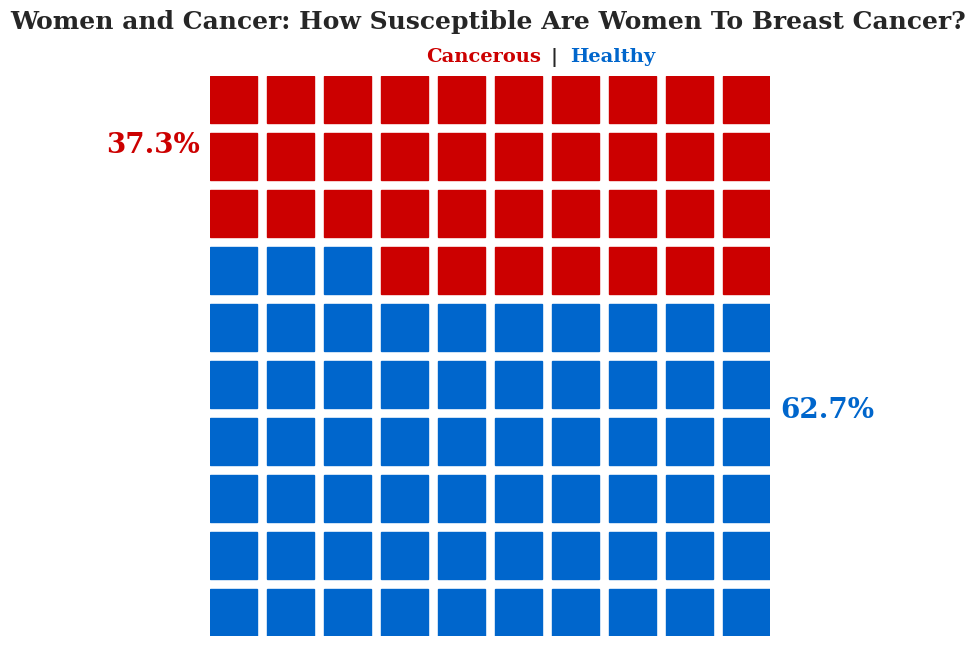

In [10]:
plot_waffle_chart(stats['benign_percent'], stats['malignant_percent'])

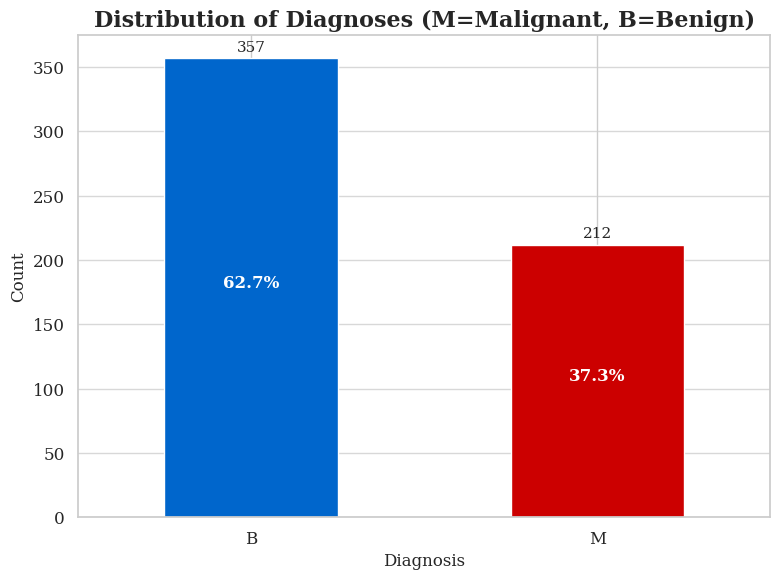

In [11]:
plot_diagnosis_bar_chart(stats['diagnosis_counts'])

Then we examine feature distributions.

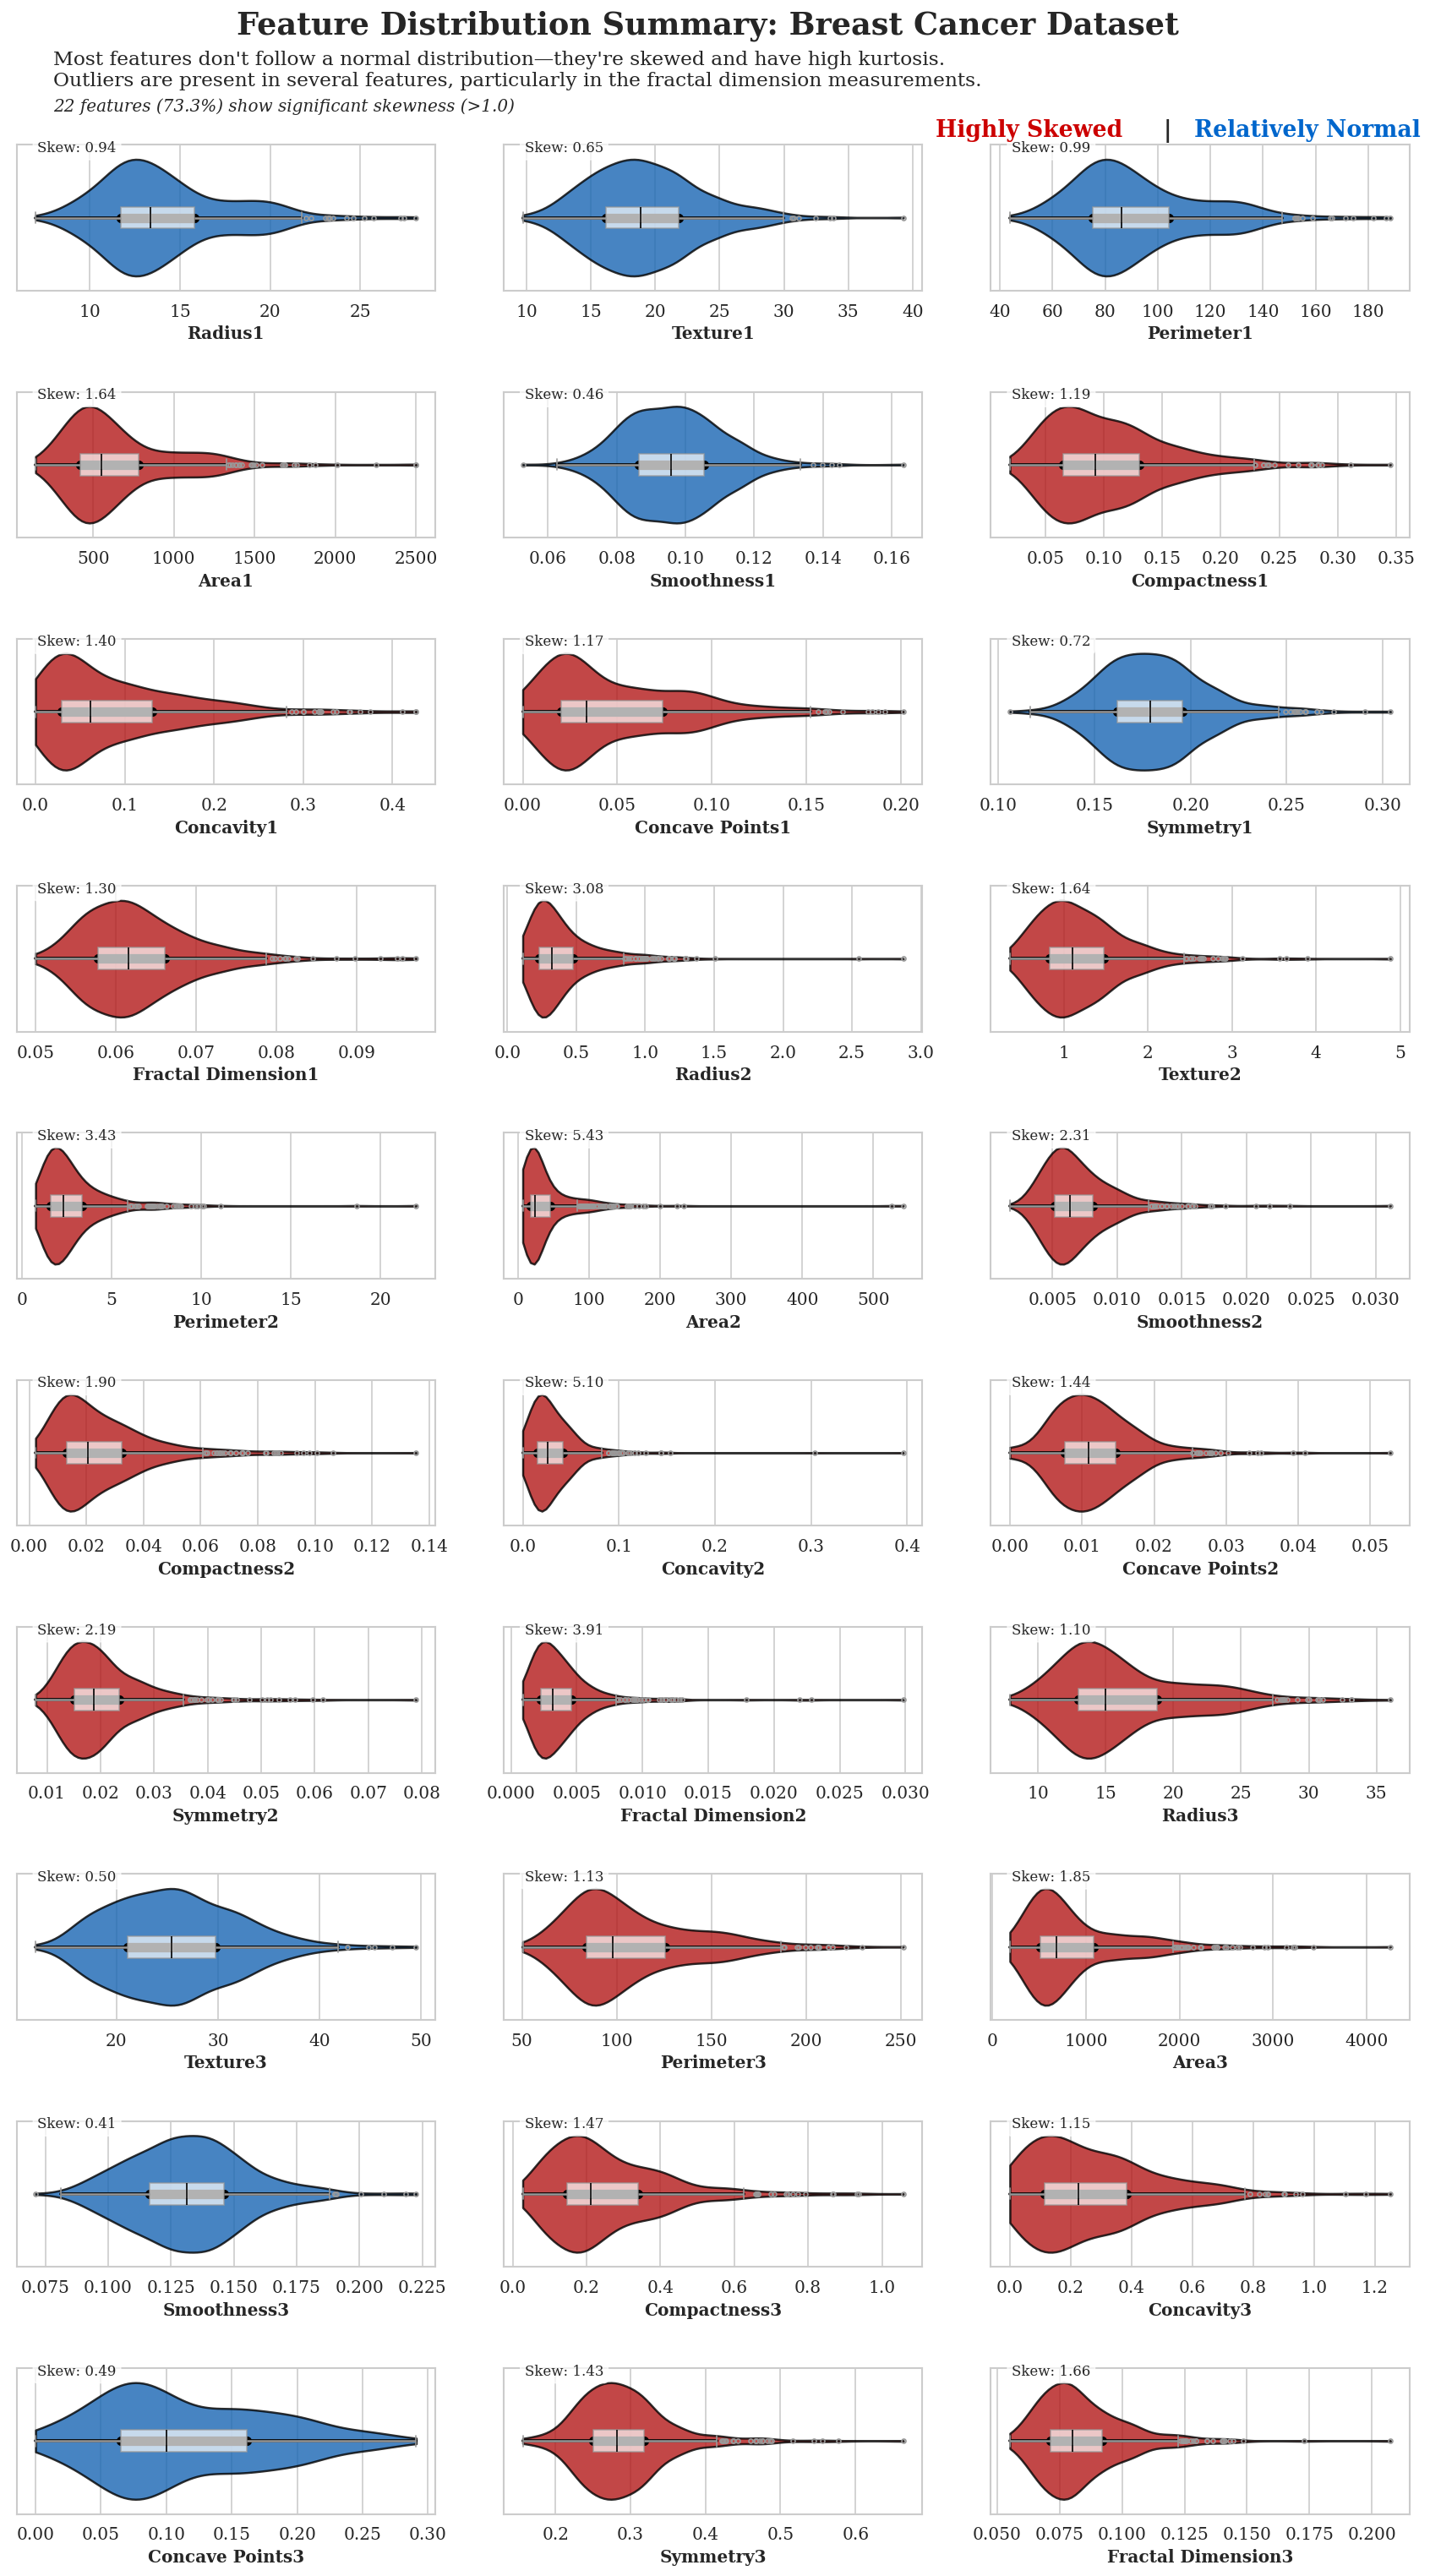

In [12]:
plot_feature_distributions(breast_cancer_df)

Next, we analyze KDE distributions.

<ipython-input-9-8204a64d529b>:163: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, ax=ax, fill=True,


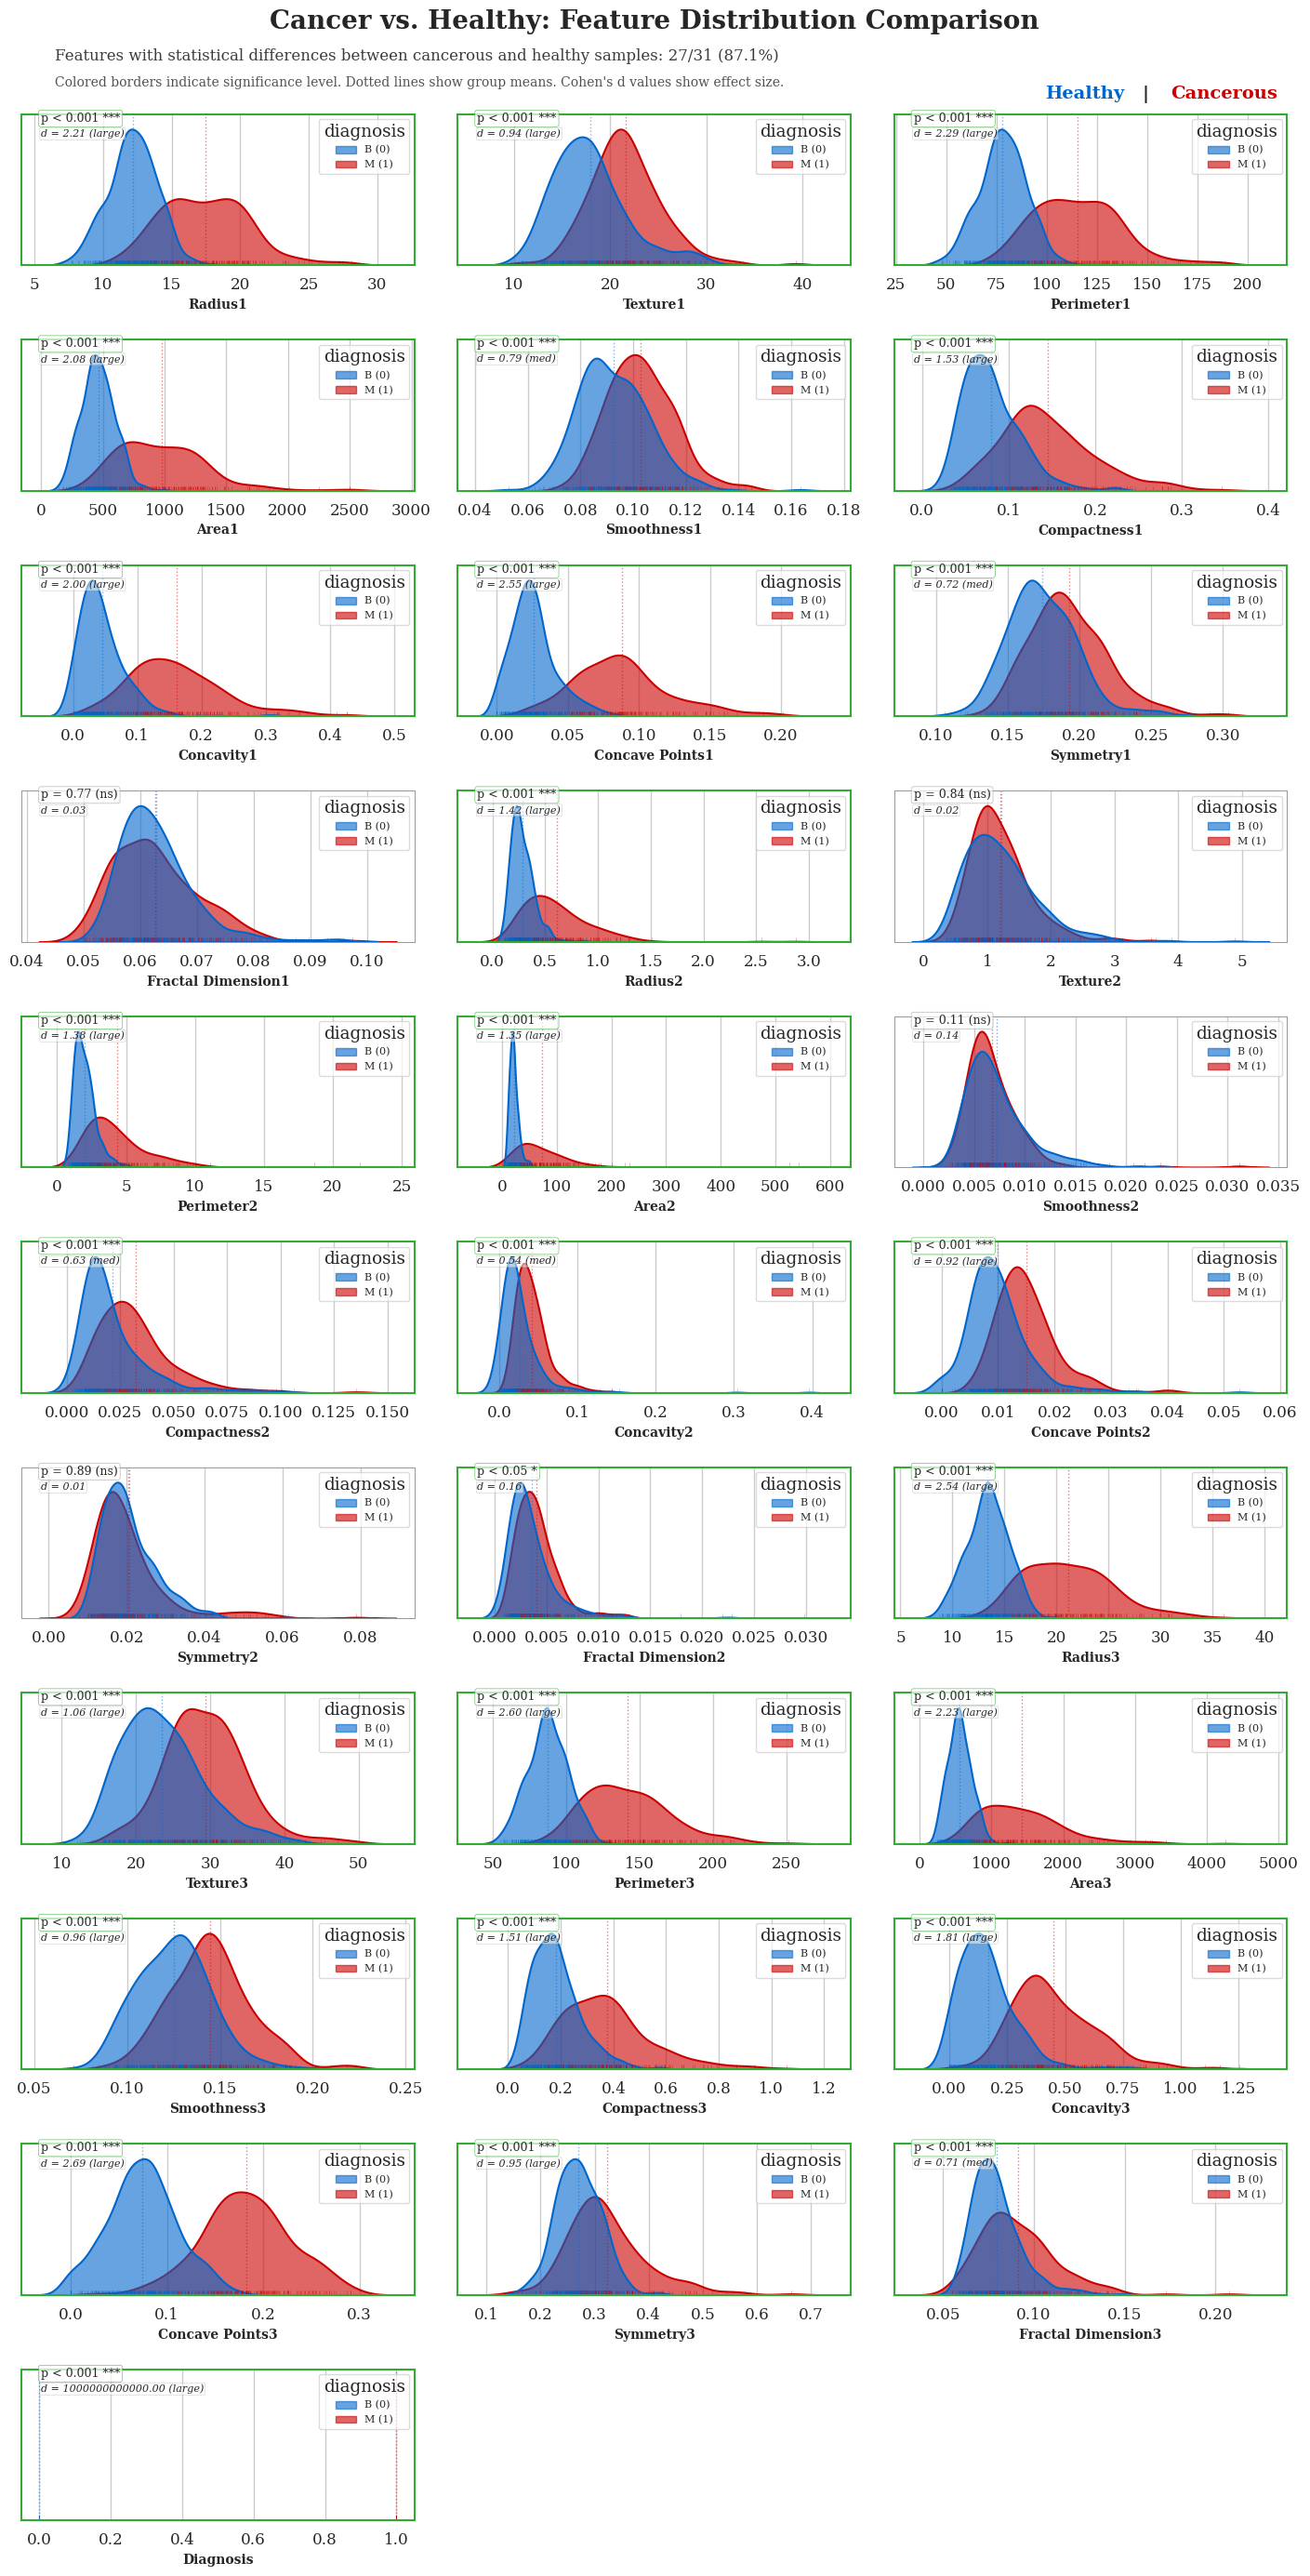

In [13]:
plot_kde_distributions(
        breast_cancer_df,
        breast_cancer_df_features_only,
        malignant_df,
        benign_df,
        stats['p_values'],
        stats['effect_sizes']
    )

We then create pairplots between features related to distances and characteristics.

<ipython-input-9-8204a64d529b>:381: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_box = plt.Rectangle(


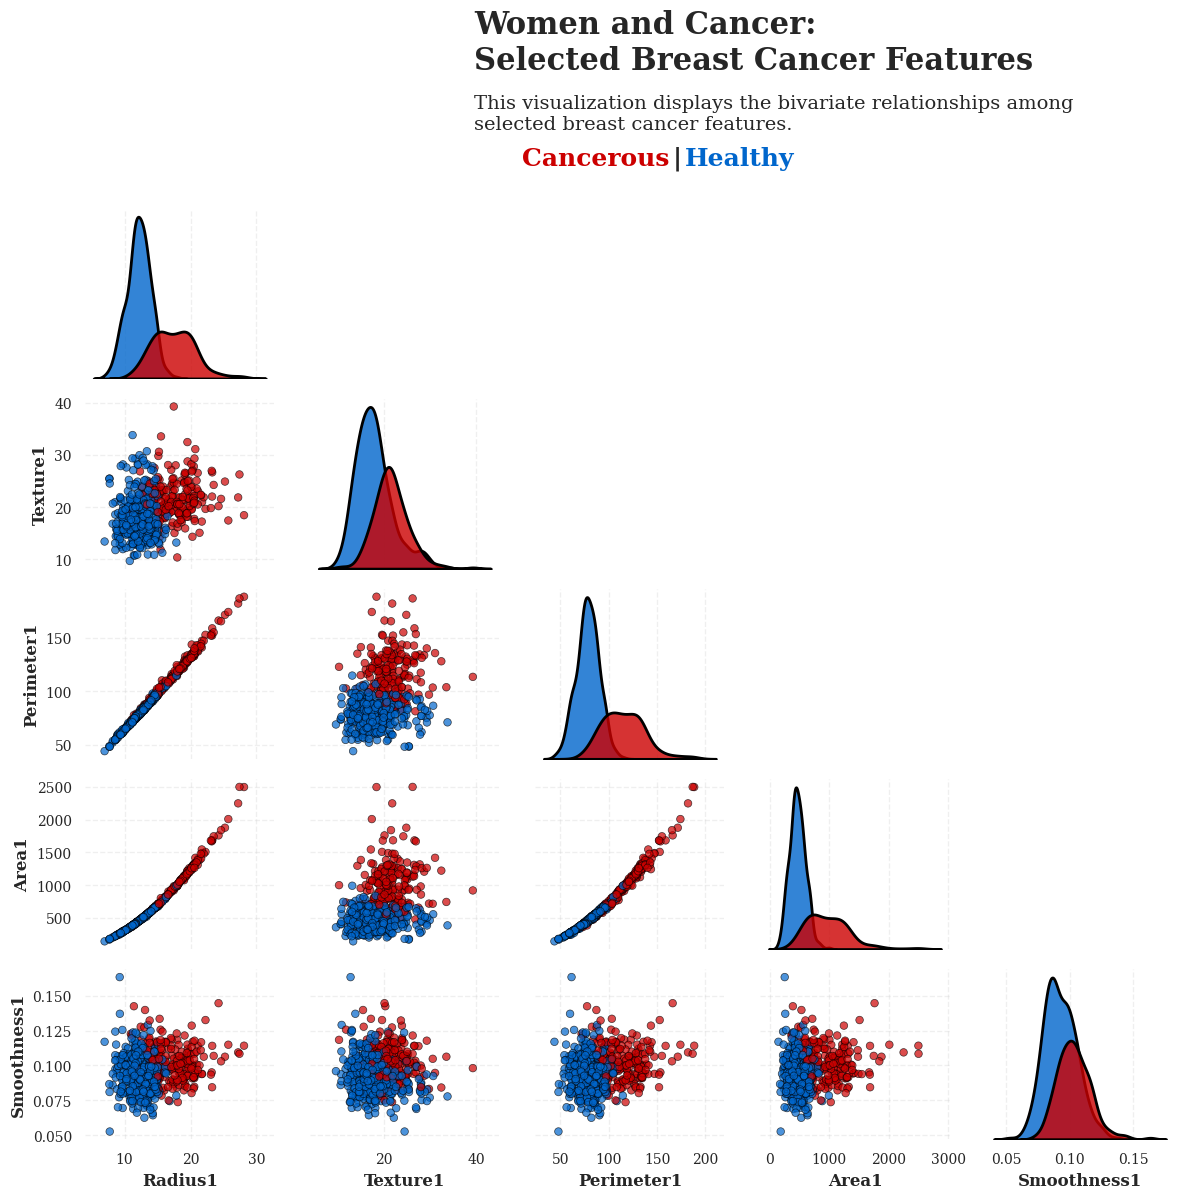

In [14]:
selected_features = ['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1']
g = direct_feature_pairplot(
    breast_cancer_df,
    selected_features,
    'Selected Breast Cancer Features',
    sign='on'
)
plt.show()

<ipython-input-9-8204a64d529b>:381: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_box = plt.Rectangle(


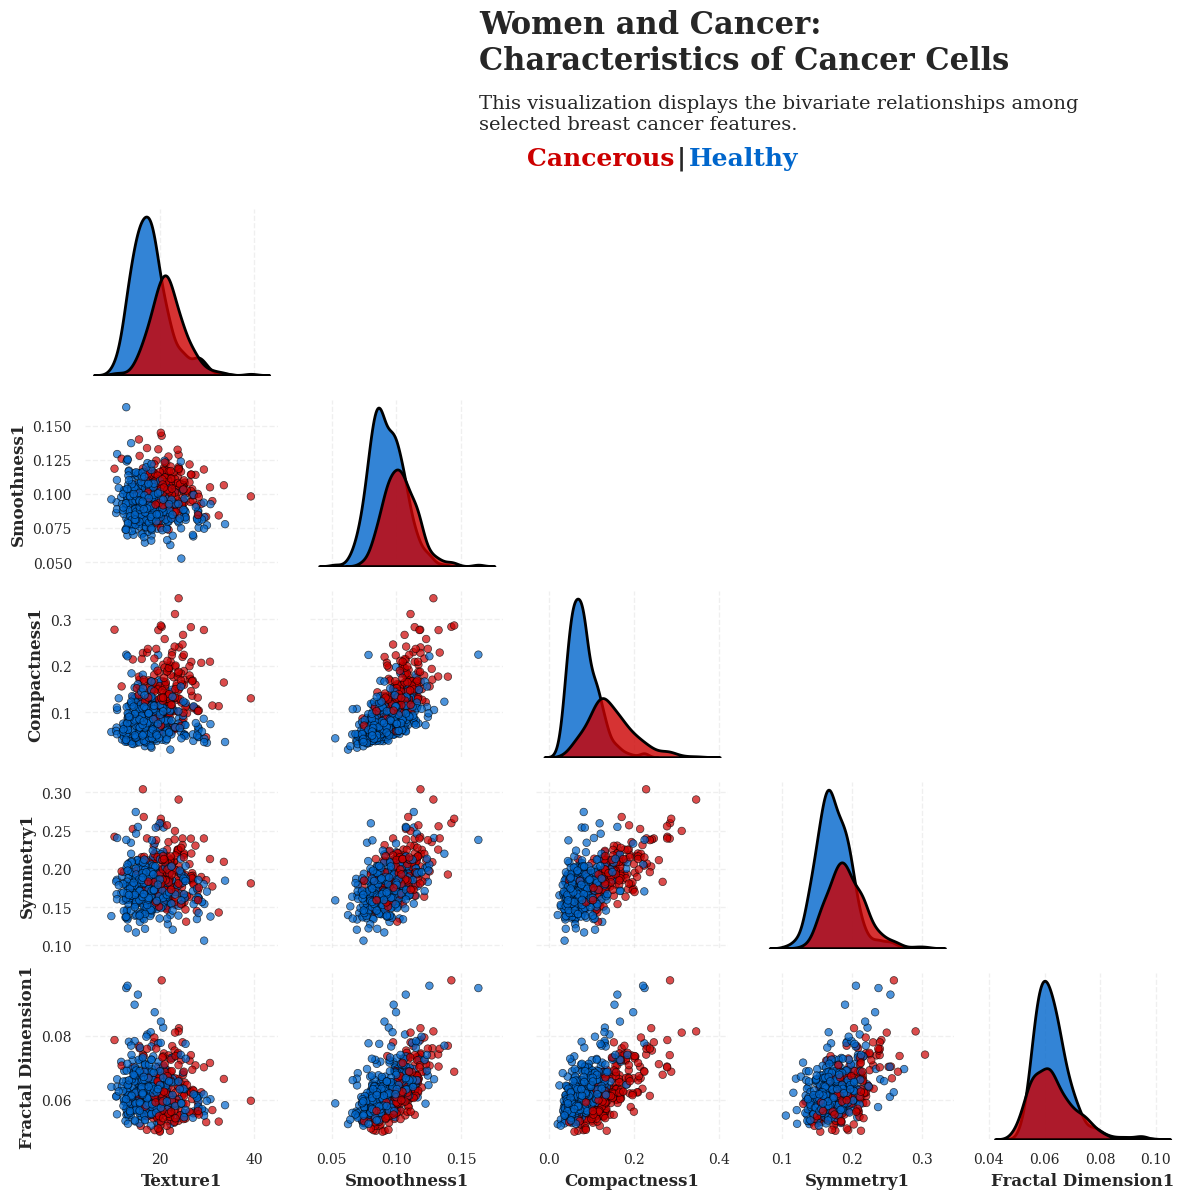

In [15]:
characteristic_features = [
  'texture1',      # texture
  'smoothness1',   # smoothness
  'compactness1',  # compactness
  'symmetry1',     # symmetry
  'fractal_dimension1'  # fractal dimension
]
g = direct_feature_pairplot(
  breast_cancer_df,
  characteristic_features,
  'Characteristics of Cancer Cells',
  sign='on'
)
plt.show()

Finally, we examine correlations between features and diagnosing breast cancer where features with *** are significant for diagnosing breast cancer.

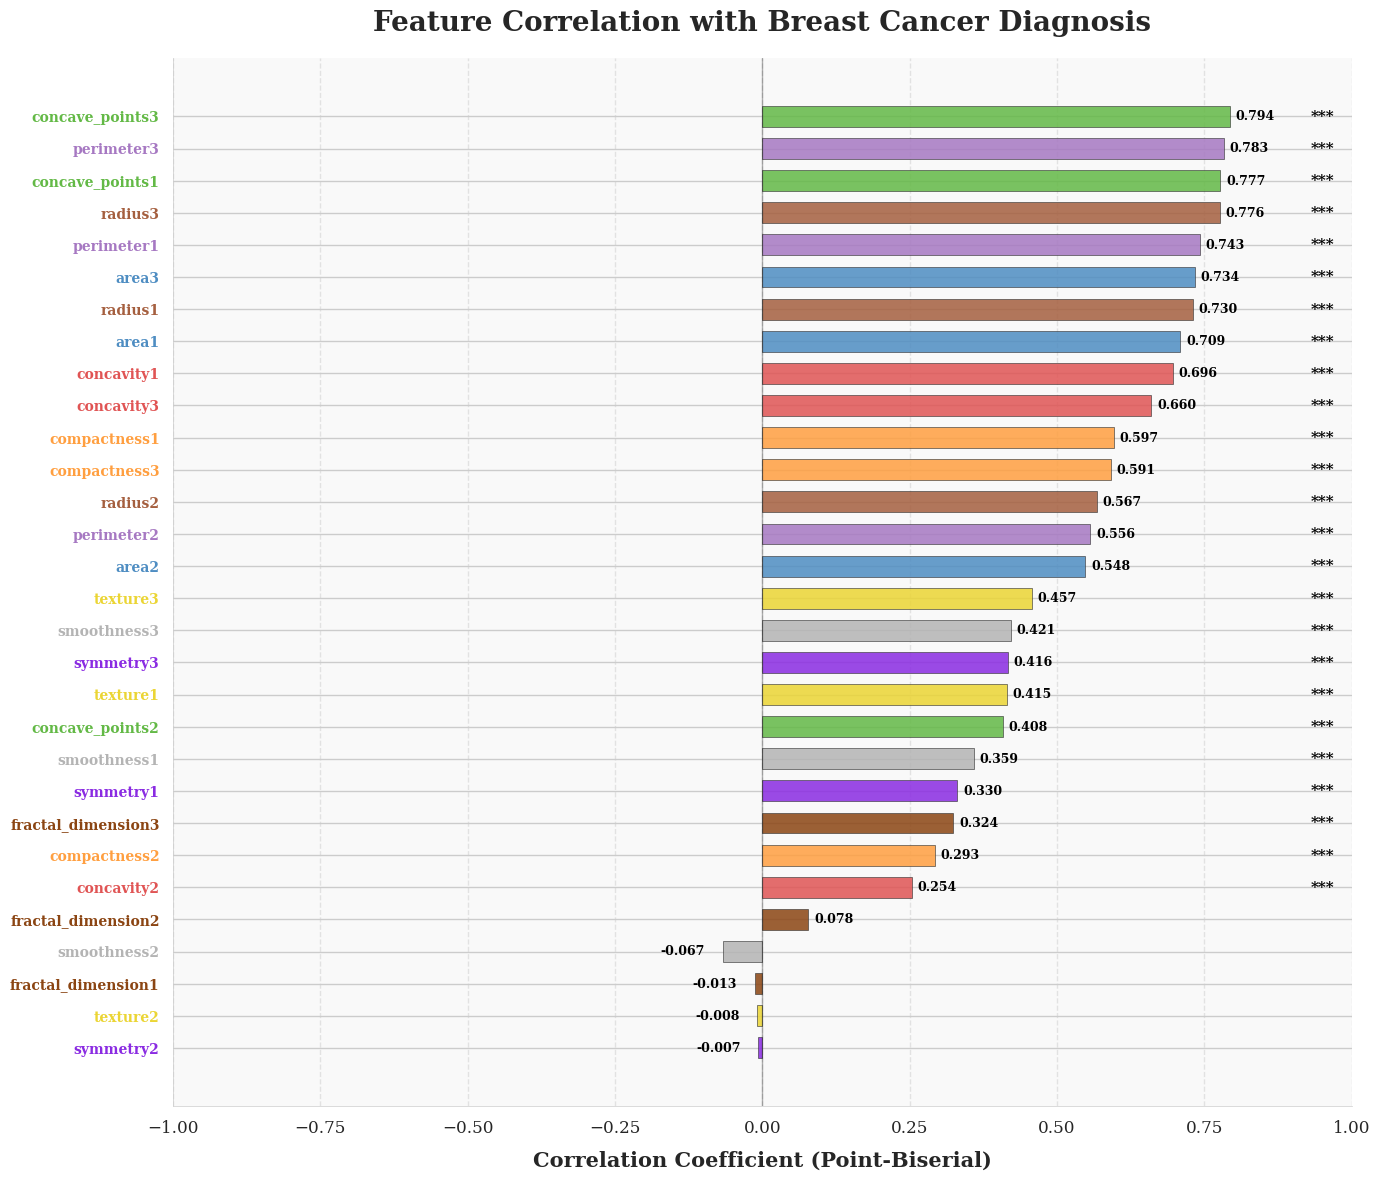

In [16]:
corr_with_diagnosis = calculate_feature_correlations(breast_cancer_df)
fig, axes = visualize_diagnosis_correlations(corr_with_diagnosis, n_features=30)
plt.show()

The features associated with the size and shape of the breast mass are highly correlated with predicting breast cancer.

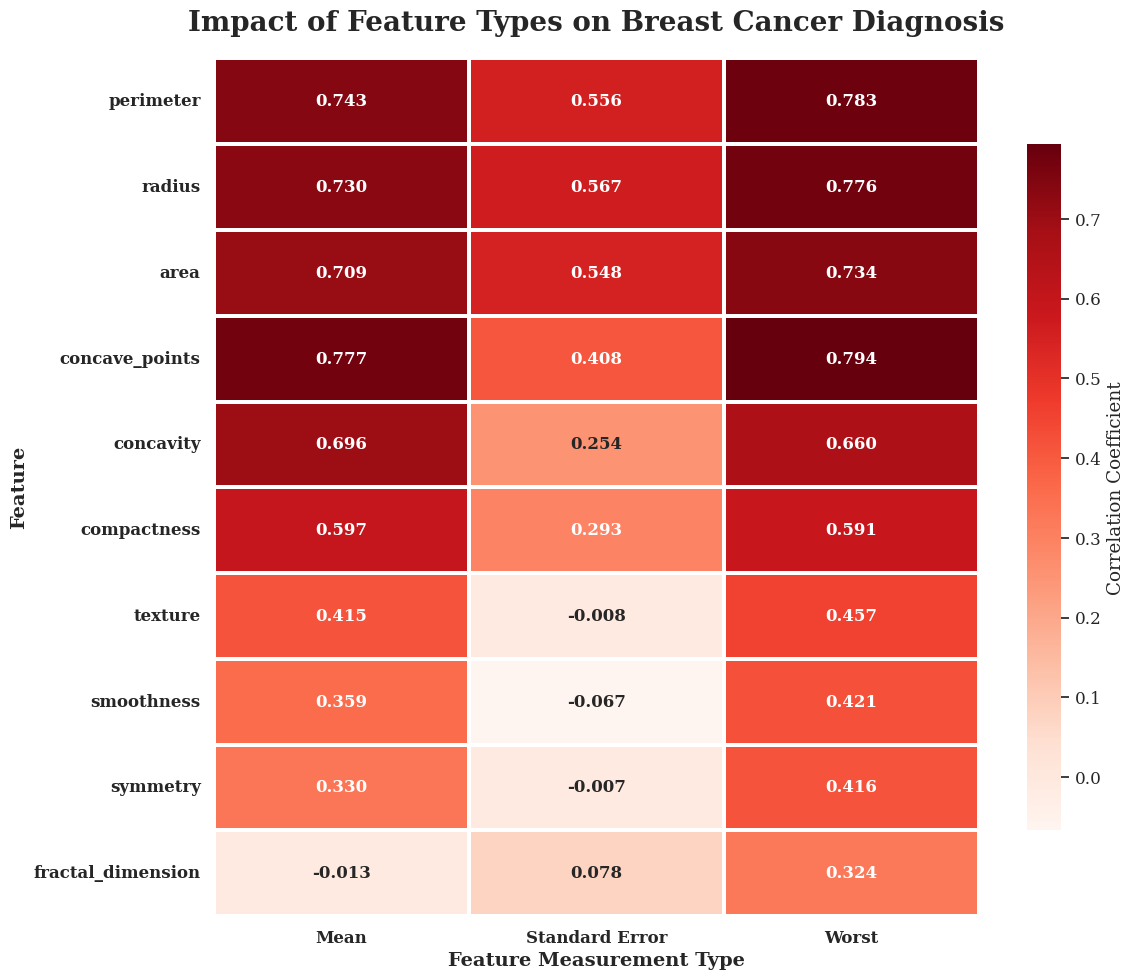

In [17]:
feature_type_analysis = analyze_feature_types(corr_with_diagnosis)

## Data Preprocessing
We now create a train and test set based on the features most correlated with diagnosing breast cancer.

In [18]:
# Significant features
significant_features = [
    'concave_points3', 'perimeter3', 'concave_points1', 'radius3',
    'perimeter1', 'area3', 'radius1', 'area1', 'concavity1',
    'concavity3', 'compactness1', 'compactness3', 'radius2',
    'perimeter2', 'area2', 'texture3', 'smoothness3', 'symmetry3',
    'texture1', 'concave_points2', 'smoothness1', 'symmetry1',
    'fractal_dimension3', 'compactness2', 'concavity2'
]

# Features correlated with diagnosing breast cancer
X = breast_cancer_df[significant_features].values  # Selected features
y = breast_cancer_df['diagnosis'].values           # Labels

# Split into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=1)

print("Data split:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")

# Create a standardized version of the dataset (Z-score normalization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Data split:
  Training set: 455 samples
  Test set: 114 samples


## Establishing a Baseline
Before we start building various machine learning models, we will look at a baseline model to see how well our models perform. Our baseline will be the performance given that we predict that all patients don't have breast cancer (i.e., what would occur if we predicted that all 114 samples in `y_test` are benign).

In [19]:
print("\nBaseline Model Evaluation (Predicting All Benign):")
print("==================================================")

# Calculate accuracy of always predicting the majority class (benign)
baseline_prediction = np.zeros_like(y_test)  # Predict all as benign (0)
baseline_accuracy = accuracy_score(y_test, baseline_prediction)

print(f"Baseline (All Benign): {baseline_accuracy:.4f}")

# Calculate the percentage of benign samples in the dataset
benign_percentage = (len(benign_df) / len(breast_cancer_df)) * 100
print(f"Percentage of benign samples in dataset: {benign_percentage:.2f}%")


Baseline Model Evaluation (Predicting All Benign):
Baseline (All Benign): 0.6316
Percentage of benign samples in dataset: 62.74%


Therefore, in order for any supervised machine learning technique to be effective on this problem, it must beat the 63.16\% accuracy of the baseline prediction that no patients have breast cancer.

We will try a variety of different machine learning methods for binary classification. The image below shows a vanilla neural network for our dataset with 8 feature inputs, three hidden layers with decreasing neurons, and a binary output classifying tumors as malignant or benign.


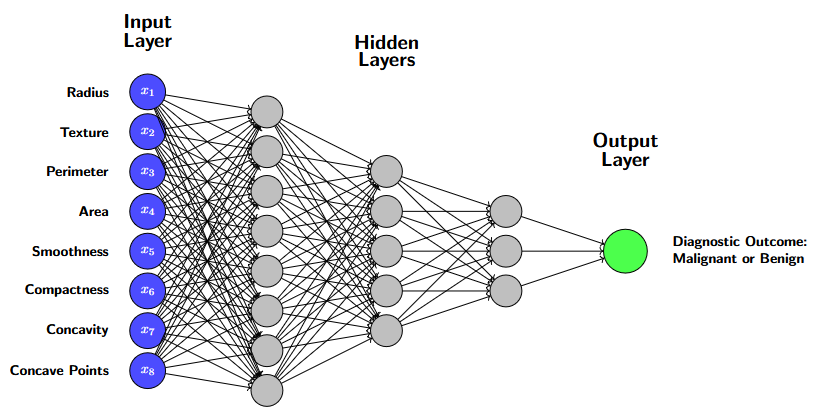

**Figure:** Feed forward neural network for predicting an outcome of malignant of benign.

## Model Evaluation (Original Data)
We begin by evaluating model performance without normalizing the dataset.

In [20]:
# Models to evaluate
models = [
    ('LR', OneVsRestClassifier(LogisticRegression(solver='liblinear'))),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier()),
    ('NB', GaussianNB()),
    ('SVM', SVC(gamma='auto')),
    ('XGB', XGBClassifier(eval_metric='logloss')),
    ('RF', RandomForestClassifier(n_estimators=100))
]

# Model evaluation wtith 10-fold cross-validation
print("\nModel Evaluation on Original Data (10-fold CV):")
print("================================================")

results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f'{name}: {cv_results.mean():.4f} (±{cv_results.std():.4f})')

# Percentage of benign samples in training data
benign_percent = np.mean(y_train == 0)

# Baseline accuracy
baseline_accuracy = benign_percent  # Accuracy when always predicting majority class
baseline_results = np.full(10, baseline_accuracy)  # 10 folds, all with same value

# Add baseline to results and names
results.insert(0, baseline_results)
names.insert(0, 'Baseline')

print(f"Baseline: {baseline_accuracy:.4f}")


Model Evaluation on Original Data (10-fold CV):
LR: 0.9473 (±0.0341)
LDA: 0.9517 (±0.0336)
KNN: 0.9166 (±0.0412)
CART: 0.9341 (±0.0240)
NB: 0.9364 (±0.0420)
SVM: 0.6263 (±0.0041)
XGB: 0.9604 (±0.0238)
RF: 0.9518 (±0.0398)
Baseline: 0.6264


We include a helper function for visualizing model performance.

In [21]:
# @title
def plot_model_comparison(results, names):
    """
    Create an enhanced box plot visualization for algorithm comparison,
    including all algorithms regardless of performance.

    Parameters:
    -----------
    results : list of arrays
        Cross-validation results for each algorithm
    names : list
        Names of the algorithms
    """

    # Plot styling
    plt.style.use('ggplot')
    sns.set(style="whitegrid", context="notebook", font_scale=1.1)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['axes.titleweight'] = 'bold'
    fig, ax = plt.subplots(figsize=(14, 8), dpi=100, facecolor='white')
    colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f', '#edc948']

    box = ax.boxplot(
        results,
        patch_artist=True,
        widths=0.6,
        medianprops={
            'color': 'black',
            'linewidth': 2
        },
        whiskerprops={
            'linewidth': 1.5
        },
        capprops={
            'linewidth': 1.5
        },
        flierprops={
            'marker': 'o',
            'markerfacecolor': 'white',
            'markeredgecolor': 'black',
            'markersize': 6
        }
    )

    # Box colors
    for patch, color in zip(box['boxes'], colors[:len(results)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)

    # Mean accuracy for every algorithm
    for i, result in enumerate(results):
      mean = np.mean(result)
      # Position all mean labels above the boxes
      y_offset = 0.025

      ax.text(
          i + 1,
          mean + y_offset,
          f"Mean: {mean:.3f}",
          fontweight='bold',
          fontsize=10,
          ha='center',
          va='bottom'
      )

    # Horizontal line at 0.9 accuracy
    ax.axhline(y=0.9, color='#cc0000', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.text(
        len(results) + 0.25,
        0.901,
        '90% Accuracy',
        fontsize=11,
        fontweight='bold',
        color='#cc0000',
        va='bottom'
    )

    # Improve formatting
    ax.set_title('Breast Cancer Classification: Algorithm Performance Comparison', fontsize=20, pad=20)
    ax.set_ylabel('Accuracy (10-fold CV)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Classification Algorithms', fontsize=16, fontweight='bold')
    ax.set_xticklabels(names, fontsize=12, fontweight='bold')
    min_value = min([np.min(result) for result in results])
    max_value = max([np.max(result) for result in results])

    y_min = max(0.6, min_value - 0.05)  # Don't go below 0.6 (60%)
    y_max = min(1.0, max_value + 0.03)  # Don't go above 1.0 (100%)

    ax.set_ylim(y_min, y_max)

    ytick_range = np.linspace(y_min, y_max, 8)
    ax.set_yticks(ytick_range)
    ax.set_yticklabels([f"{tick:.0%}" for tick in ytick_range], fontsize=12)

    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    # Performance ranking
    algo_means = [(name, np.mean(result)) for name, result in zip(names, results)]
    algo_means.sort(key=lambda x: x[1], reverse=True)

    ranking_text = "Performance Ranking:\n"
    for i, (name, mean) in enumerate(algo_means):
        ranking_text += f"{i+1}. {name}: {mean:.3f}\n"

    fig.text(
        0.85,
        0.35,
        ranking_text,
        fontsize=12,
        fontweight='bold',
        fontfamily='serif',
        bbox=dict(
            facecolor='white',
            alpha=0.8,
            edgecolor='gray',
            boxstyle='round,pad=0.5'
        )
    )

    # Performance differences
    high_performers = [name for name, mean in algo_means if mean > 0.9]
    low_performers = [name for name, mean in algo_means if mean < 0.7]

    if low_performers and high_performers:
        performance_gap_text = (
            f"Note: {', '.join(high_performers)} achieved >90% accuracy, while "
            f"{', '.join(low_performers)} performed significantly lower at <70% accuracy."
        )

        fig.text(
            0.5,
            0.04,
            performance_gap_text,
            fontsize=10,
            fontstyle='italic',
            ha='center',
            color='#555555'
        )

    fig.text(
        0.5,
        0.01,
        "Results based on 10-fold cross-validation.",
        fontsize=10,
        fontstyle='italic',
        ha='center'
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    return fig, ax

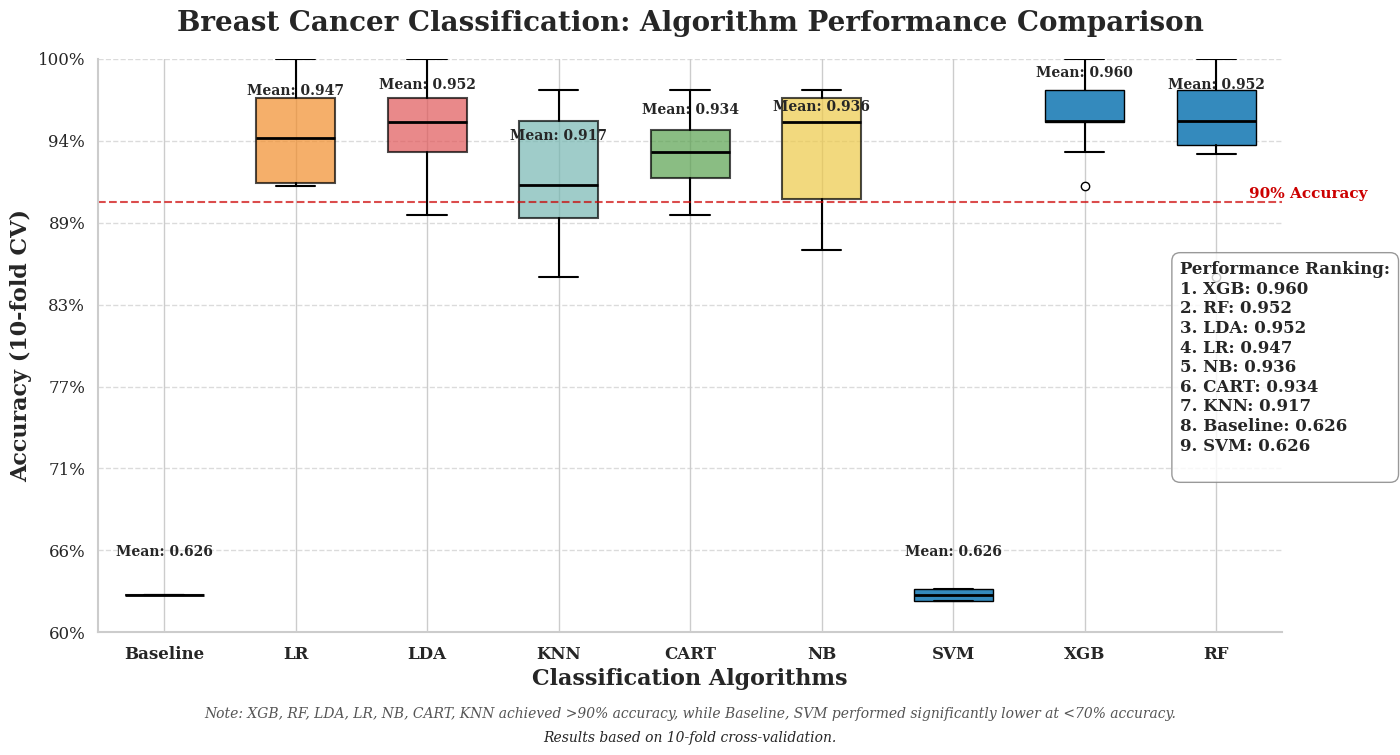

In [22]:
# Visualize model comparison with box plots for normal data
fig, ax = plot_model_comparison(results, names)
plt.show()

# Highlight the baseline
ax.get_xticklabels()[0].set_color('red')
ax.get_xticklabels()[0].set_fontweight('bold')

## Model Evaluation (Standardized Data)
Next we evaluated the models after standardizing the dataset.

In [23]:
# Evaluate each model 10-fold cross-validation on standardized data
print("\nModel Evaluation on Standardized Data (10-fold CV):")
print("===================================================")

results_scaled = []
names_scaled = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='accuracy')
    results_scaled.append(cv_results)
    names_scaled.append(name)
    print(f'{name}: {cv_results.mean():.4f} (±{cv_results.std():.4f})')

# Percentage of benign samples in training data
benign_percent = np.mean(y_train == 0)

# Baseline accuracy
baseline_accuracy = benign_percent  # Accuracy when always predicting majority class
baseline_results = np.full(10, baseline_accuracy)  # 10 folds, all with same value

# Add baseline to results and names
results_scaled.insert(0, baseline_results)
names_scaled.insert(0, 'Baseline')

print(f"Baseline: {baseline_accuracy:.4f}")


Model Evaluation on Standardized Data (10-fold CV):
LR: 0.9801 (±0.0184)
LDA: 0.9517 (±0.0336)
KNN: 0.9780 (±0.0197)
CART: 0.9342 (±0.0192)
NB: 0.9320 (±0.0463)
SVM: 0.9758 (±0.0229)
XGB: 0.9604 (±0.0238)
RF: 0.9605 (±0.0305)
Baseline: 0.6264


In [24]:
# @title
def plot_model_comparison_standardized(results, names):
    """
    Create an enhanced box plot visualization for algorithm comparison.

    Parameters:
    -----------
    results : list of arrays
        Cross-validation results for each algorithm
    names : list
        Names of the algorithms
    """

    # Improve styling
    plt.style.use('ggplot')
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['axes.titleweight'] = 'bold'

    fig, ax = plt.subplots(figsize=(14, 10), dpi=100, facecolor='white')

    colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f', '#edc949']

    box = ax.boxplot(
        results,
        patch_artist=True,
        widths=0.6,
        medianprops={
            'color': 'black',
            'linewidth': 2
        },
        whiskerprops={
            'linewidth': 1.5
        },
        capprops={
            'linewidth': 1.5
        },
        flierprops={
            'marker': 'o',
            'markerfacecolor': 'white',
            'markeredgecolor': 'black',
            'markersize': 6
        }
    )

    for patch, color in zip(box['boxes'], colors[:len(results)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)

    # Mean and standard deviation for every algorithm
    mean_values = [np.mean(result) for result in results]
    std_values = [np.std(result) for result in results]

    all_values = [value for result in results for value in result]
    overall_min = min(all_values)
    overall_max = max(all_values)

    y_min = max(0.61, overall_min - 0.05)  # Don't go below 61%
    y_max = 1.01

    # Add mean values above boxes
    for i, (mean, std, result) in enumerate(zip(mean_values, std_values, results)):
      y_offset = 0.02  # Add an offset above the mean
      text_box = ax.text(
          i + 1,
          mean + y_offset,
          f"Mean: {mean:.3f}",
          ha='center',
          va='bottom',
          fontweight='bold',
          fontsize=10,
          bbox=dict(
              facecolor='white',
              alpha=0.8,
              edgecolor='black',
              boxstyle='round,pad=0.3',
              linewidth=1
          )
      )

    # Horizontal line at 90% accuracy
    ax.axhline(y=0.9, color='#cc0000', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.text(
        len(results) + 0.35,
        0.902,
        '90% Accuracy',
        fontsize=11,
        fontweight='bold',
        color='#cc0000',
        va='bottom'
    )

    # Improve plot formatting
    ax.set_title('Breast Cancer Classification: Algorithm Performance Comparison (Standardized Data)', fontsize=22, pad=20)
    ax.set_ylabel('Accuracy (10-fold CV)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Classification Algorithms', fontsize=16, fontweight='bold')

    ax.set_xticklabels(names, fontsize=14, fontweight='bold')
    ax.set_ylim(y_min, y_max)

    ytick_range = np.arange(np.floor(y_min * 100) / 100, 1.01, 0.03)
    ax.set_yticks(ytick_range)
    ax.set_yticklabels([f"{int(tick*100)}%" for tick in ytick_range], fontsize=12)

    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    sorted_indices = np.argsort(mean_values)[::-1]  # Sort by mean performance (descending)
    ranking_text = "Performance Ranking:"

    for rank, idx in enumerate(sorted_indices):
        ranking_text += f"\n{rank+1}. {names[idx]}: {mean_values[idx]:.3f}"

    props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
    ax.text(
        0.97,
        0.57,
        ranking_text,
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold',
        verticalalignment='top',
        horizontalalignment='right',
        bbox=props
    )

    fig.text(
        0.5,
        0.01,
        "Results based on 10-fold cross-validation.",
        fontsize=10,
        fontstyle='italic',
        ha='center'
    )

    plt.tight_layout(rect=[0, 0.02, 1, 0.98])
    return fig, ax

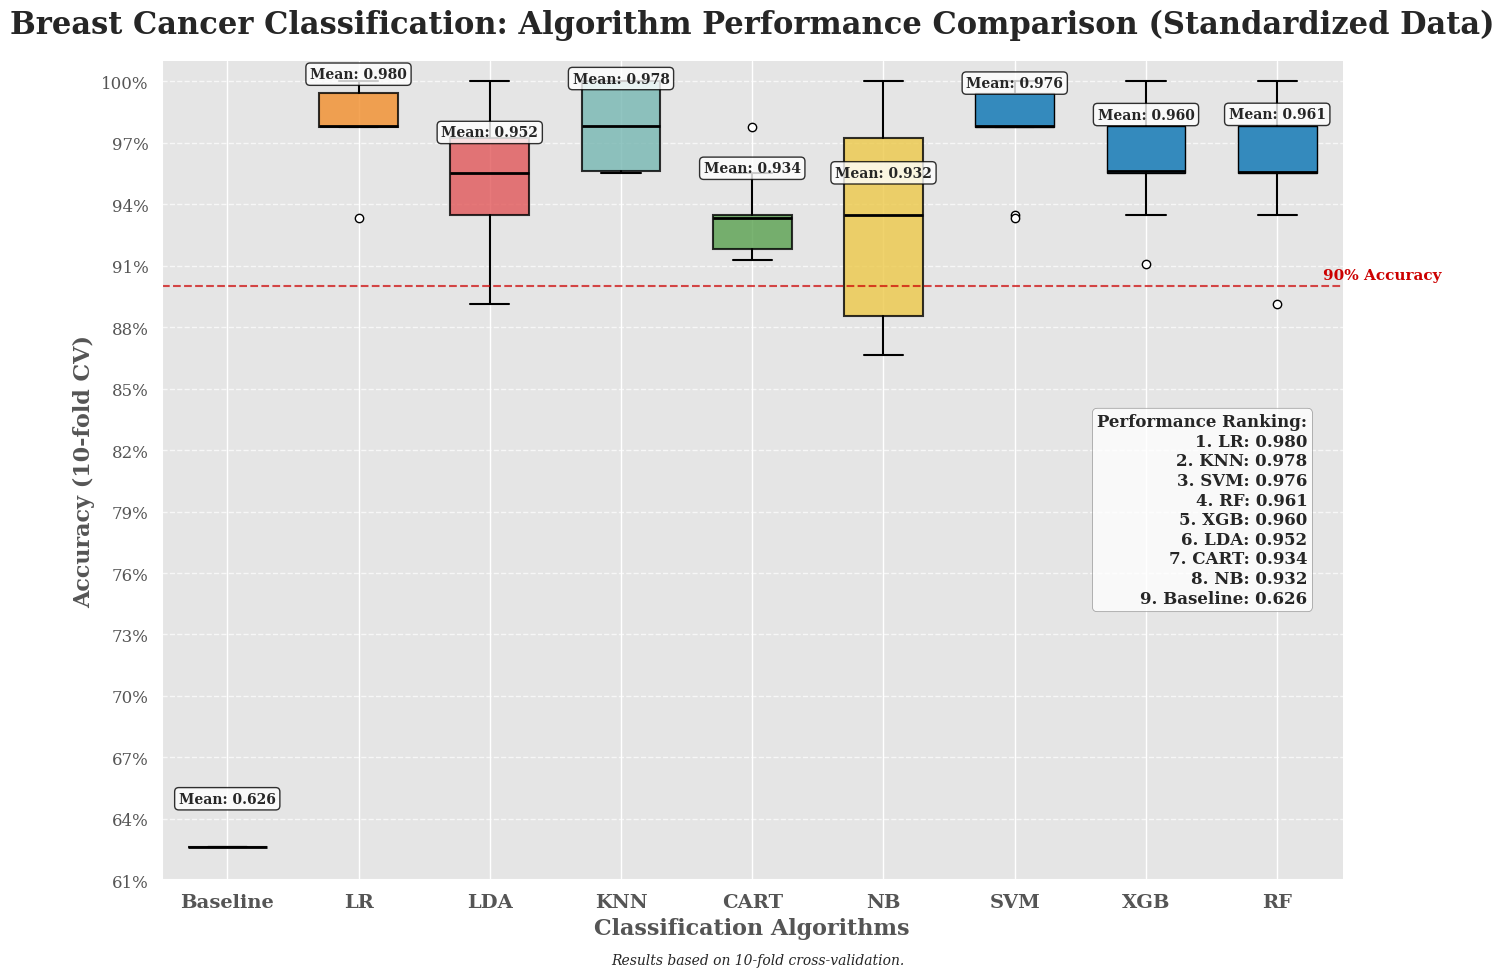

In [25]:
fig, ax = plot_model_comparison_standardized(results_scaled, names_scaled)
plt.show()

## Final Model Selection and Evaluation
By the analysis above, we see that logistic regression outperformed all other classification algorithms on the standardized dataset. Its performance is slightly above 98\%.

In [26]:
# The best model (SVM with standardized data)
best_model = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
best_model.fit(X_train_scaled, y_train)
predictions = best_model.predict(X_test_scaled)

# Evaluate the best model's performance
print("\nBest Model Evaluation (Logistic Regression with standardized data):")
print("===================================================")
print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")


Best Model Evaluation (Logistic Regression with standardized data):
Accuracy: 0.9825


This model accurately predicts breast cancer on the Wisconsin dataset.

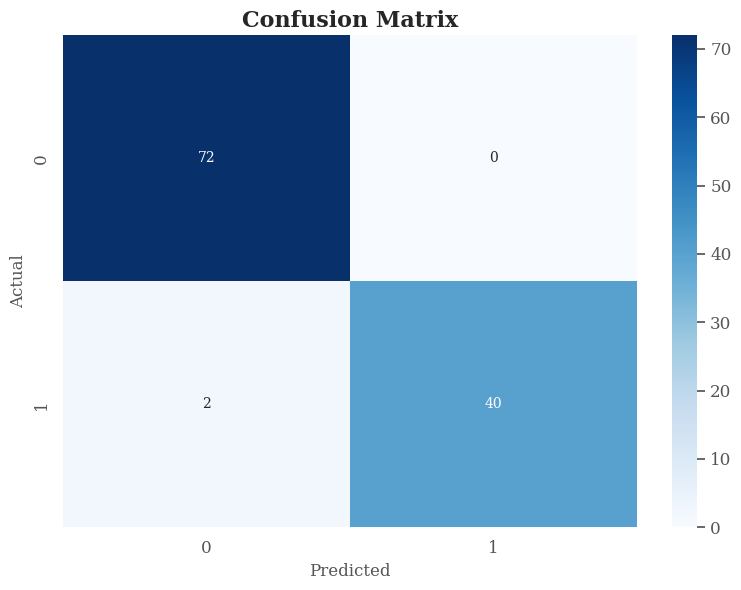

In [27]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

In [28]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=['Benign', 'Malignant']))


Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      1.00      0.99        72
   Malignant       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



## Feature Importance Analysis
We once again examine important features for diagnosing breast cancer.

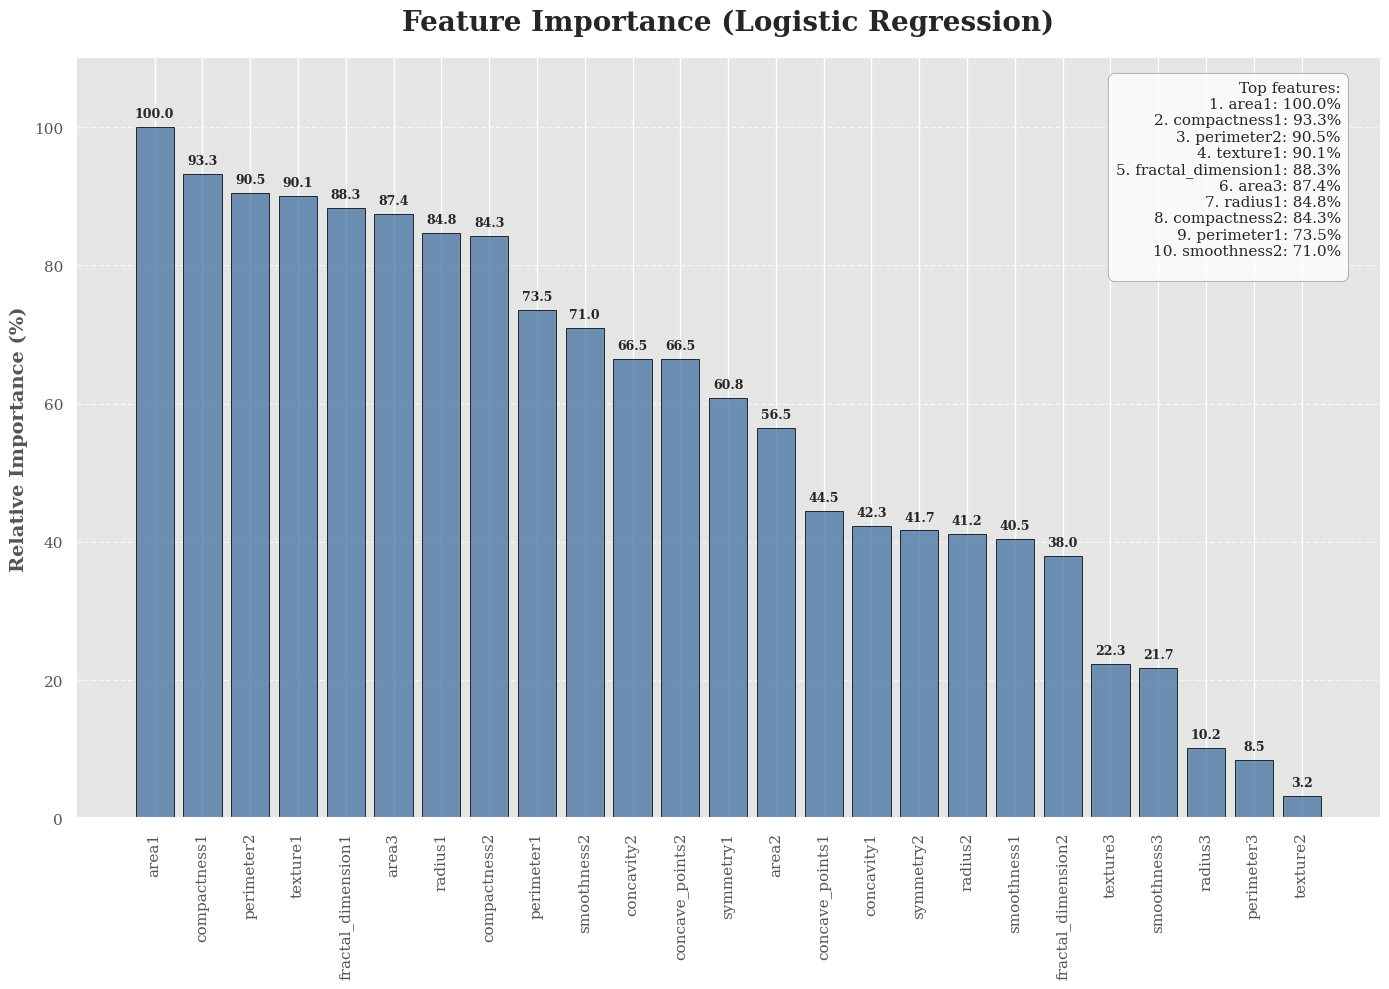

In [29]:
# Visualize feature importance
lr_model = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
lr_model.fit(X_train_scaled, y_train)

feature_importance = abs(lr_model.estimators_[0].coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
indices = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(14, 10))
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'

bars = plt.bar(
    range(X_train_scaled.shape[1]),
    feature_importance[indices],
    color='#4e79a7',
    alpha=0.8,
    edgecolor='black',
    linewidth=0.7
)

# Feature value labels
for i, v in enumerate(feature_importance[indices]):
    plt.text(
        i,
        v + 1,
        f"{v:.1f}",
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )

plt.xticks(
    range(X_train_scaled.shape[1]),
    np.array(feature_names)[indices],
    rotation=90,
    fontsize=11
)
plt.yticks(fontsize=11)
plt.ylabel('Relative Importance (%)', fontsize=14, fontweight='bold')
plt.title('Feature Importance (Logistic Regression)', fontsize=20, pad=20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(feature_importance) * 1.1)

# Visualize top features
top_features = [np.array(feature_names)[indices][i] for i in range(10)]
top_values = [feature_importance[indices][i] for i in range(10)]

annotation = "Top features:\n"
for i in range(10):
    annotation += f"{i+1}. {top_features[i]}: {top_values[i]:.1f}%\n"

plt.annotate(
    annotation,
    xy=(0.97, 0.97),
    xycoords='axes fraction',
    ha='right',
    va='top',
    fontsize=11,
    bbox=dict(
        boxstyle="round,pad=0.5",
        fc="white",
        ec="gray",
        alpha=0.8
    )
)

plt.tight_layout()
plt.show()

## Model Pipeline Creation
We then create a pipeline for fitting the best classification model.

In [30]:
# Reusable pipeline with preprocessing for the best model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', OneVsRestClassifier(LogisticRegression(solver='liblinear')))
])

# Evaluate the pipeline
kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
pipeline_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')
print("\nPipeline Evaluation:")
print("===================")
print(f"Accuracy: {pipeline_results.mean():.4f} (±{pipeline_results.std():.4f})")

# Fit the pipeline to the entire dataset
pipeline.fit(X, y)


Pipeline Evaluation:
Accuracy: 0.9772 (±0.0137)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(solver='liblinear')))])

## Model Predictions through Pipeline
We then use our pipeline to predict if a patient does or does not have breast cancer.

In [31]:
def predict_diagnosis(model, features):
    """
    Make a prediction using the trained model

    Parameters:
    model: Trained model or pipeline
    features: Array of features in the same order as in training data

    Returns:
    prediction: 'Malignant' or 'Benign'
    probability: Probability of the prediction (if model supports it)
    """
    if len(features.shape) == 1:
        features = features.reshape(1, -1)

    # Make prediction
    prediction = model.predict(features)[0]

    # Get probability
    try:
        probability = model.predict_proba(features)[0]
        prob_value = max(probability)
    except:
        prob_value = None

    result = 'Malignant' if prediction == 1 else 'Benign'

    return result, prob_value

# First sample from test set
sample = X_test[0]
diagnosis, probability = predict_diagnosis(pipeline, sample)

print("\nExample Prediction:")
print("==================")
print(f"Predicted diagnosis: {diagnosis}")
if probability is not None:
    print(f"Prediction probability: {probability:.4f}")
print(f"Actual diagnosis: {'Malignant' if y_test[0] == 1 else 'Benign'}")


Example Prediction:
Predicted diagnosis: Benign
Prediction probability: 0.8934
Actual diagnosis: Benign


We then repeat this for all of the test data and visualize performance on the Wisconsin Breast Cancer Dataset.

In [36]:
# @title
def visualize_predictions(model, X_test, y_test, num_samples=100):
    """
    Create a four-panel vertical visualization of model predictions, with each plot
    in its own row.

    Parameters:
    -----------
    model : trained model or pipeline
        The model to make predictions with
    X_test : array-like
        test features
    y_test : array-like
        True test labels
    num_samples : int, default=100
        Number of samples to visualize
    """

    # Improve styling
    plt.style.use('ggplot')
    plt.rcParams['font.family'] = 'serif'

    num_samples = min(num_samples, len(X_test))

    if num_samples < len(X_test):
        np.random.seed(42)  # For reproducibility
        sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    else:
        sample_indices = np.arange(len(X_test))

    X_subset = X_test[sample_indices]
    y_true = y_test[sample_indices]

    # Make predictions
    y_pred = model.predict(X_subset)

    # Get probabilities
    try:
        probabilities = model.predict_proba(X_subset)
        has_proba = True
        # Extract probability of the predicted class
        pred_probas = np.array([prob[int(pred)] for prob, pred in zip(probabilities, y_pred)])
    except:
        has_proba = False
        pred_probas = np.ones_like(y_pred)  # Default to 1.0

    results_df = pd.DataFrame({
        'Sample': np.arange(len(y_true)),
        'True': y_true,
        'Predicted': y_pred,
        'Probability': pred_probas,
        'Correct': y_true == y_pred
    })

    # Correct/Incorrect predictions
    correct_count = results_df['Correct'].sum()
    incorrect_count = len(results_df) - correct_count

    fig, axs = plt.subplots(4, 1, figsize=(12, 24), dpi=100)

    colors = {
        (0, True): '#4e79a7',   # Correct benign (blue)
        (1, True): '#e15759',   # Correct malignant (red)
        (0, False): '#9dc7e0',  # Incorrect benign (light blue)
        (1, False): '#ff9da7'   # Incorrect malignant (light red)
    }

    # First Plot: Scatter plot of prediction results
    ax1 = axs[0]

    point_colors = [colors[(true, correct)] for true, correct in zip(y_true, results_df['Correct'])]
    point_sizes = results_df['Probability'] * 100 + 50

    scatter = ax1.scatter(
        results_df.index,
        results_df['Probability'],
        c=point_colors,
        s=point_sizes,
        alpha=0.8,
        edgecolor='black',
        linewidth=0.5
    )

    ax1.set_title('Prediction Results by Sample', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Prediction Probability', fontsize=12, fontweight='bold')

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[(0, True)], markersize=10, label='Correct Benign'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[(1, True)], markersize=10, label='Correct Malignant'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[(0, False)], markersize=10, label='Incorrect Benign'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[(1, False)], markersize=10, label='Incorrect Malignant')
    ]
    ax1.legend(handles=legend_elements, loc='lower right', fontsize=10)

    # Threshold at 0.5 probability
    ax1.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)

    ax1.text(
        0.02,
        0.02,
        f"Total samples: {len(results_df)}\nCorrect: {correct_count} ({correct_count/len(results_df):.1%})\nIncorrect: {incorrect_count} ({incorrect_count/len(results_df):.1%})",
        transform=ax1.transAxes,
        fontsize=10,
        va='bottom',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3')
    )

    # Second Plot: Confusion matrix
    ax2 = axs[1]
    cm = confusion_matrix(y_true, y_pred)

    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    cm_df = pd.DataFrame(cm,
                        index=['Benign (0)', 'Malignant (1)'],
                        columns=['Predicted Benign', 'Predicted Malignant'])

    custom_cmap = LinearSegmentedColormap.from_list(
        'custom_cmap',
        ['#4e79a7', '#9dc7e0', '#ff9da7', '#e15759']
    )

    sns.heatmap(
        cm_df,
        annot=True,
        fmt='d',
        cmap=custom_cmap,
        cbar=False,
        linewidths=1,
        linecolor='black',
        square=True,
        ax=ax2
    )

    ax2.set_title('Confusion Matrix', fontsize=16, fontweight='bold')
    ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

    metrics_text = (
        f"Sensitivity (TPR): {sensitivity:.2f}\n"
        f"Specificity (TNR): {specificity:.2f}\n"
        f"Accuracy: {(tp+tn)/(tp+tn+fp+fn):.2f}"
    )

    ax2.text(
        1.05,
        0.5,
        metrics_text,
        va='center',
        fontsize=11,
        fontweight='bold',
        transform=ax2.transAxes
    )

    # Third Plot: Accuracy by class
    ax3 = axs[2]

    benign_accuracy = results_df[results_df['True'] == 0]['Correct'].mean()
    malignant_accuracy = results_df[results_df['True'] == 1]['Correct'].mean()
    benign_count = (results_df['True'] == 0).sum()
    malignant_count = (results_df['True'] == 1).sum()

    # Bar chart
    class_accuracies = [benign_accuracy, malignant_accuracy]
    class_counts = [benign_count, malignant_count]
    class_labels = ['Benign (0)', 'Malignant (1)']
    bar_colors = ['#4e79a7', '#e15759']

    bars = ax3.bar(
        class_labels,
        class_accuracies,
        color=bar_colors,
        alpha=0.8,
        edgecolor='black',
        linewidth=1,
        width=0.6
    )

    # Add accuracy values on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax3.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.02,
            f'{class_accuracies[i]:.2f}',
            ha='center',
            va='bottom',
            fontweight='bold',
            fontsize=12
        )

        ax3.text(
            bar.get_x() + bar.get_width()/2.,
            height/2,
            f'n={class_counts[i]}',
            ha='center',
            va='center',
            fontsize=11,
            fontweight='bold',
            color='white'
        )

    ax3.set_title('Prediction Accuracy by Class', fontsize=16, fontweight='bold')
    ax3.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax3.set_ylim(0, 1.1)

    # 90% accuracy line
    ax3.axhline(y=0.9, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    ax3.text(
        1.5,
        0.91,
        '90% Accuracy',
        fontsize=10,
        fontweight='bold',
        va='bottom',
        ha='center'
    )

    # Fourth Plot: Accuracy by sample group
    ax4 = axs[3]

    sample_ranges = np.array_split(np.arange(len(y_true)), 5)  # 5 groups
    range_accuracies = []

    for i, sample_range in enumerate(sample_ranges):
        if len(sample_range) > 0:
            accuracy = np.mean(y_true[sample_range] == y_pred[sample_range])
            range_accuracies.append((i, accuracy, len(sample_range)))

    range_indices = [f"{r[0]*20}-{min((r[0]+1)*20, 100)}" for r in range_accuracies]
    accuracies = [r[1] for r in range_accuracies]
    sample_counts = [r[2] for r in range_accuracies]

    bars = ax4.bar(
        range_indices,
        accuracies,
        alpha=0.8,
        edgecolor='black',
        linewidth=1,
        width=0.6
    )

    # Accuracy (red for lower accuracy, blue for higher)
    for i, bar in enumerate(bars):
        if accuracies[i] < 0.9:
            bar.set_color('#e15759')
        else:
            bar.set_color('#4e79a7')

        ax4.text(
            bar.get_x() + bar.get_width()/2.,
            accuracies[i] + 0.02,
            f'{accuracies[i]:.2f}',
            ha='center',
            va='bottom',
            fontweight='bold',
            fontsize=10
        )

        ax4.text(
            bar.get_x() + bar.get_width()/2.,
            accuracies[i]/2,
            f'n={sample_counts[i]}',
            ha='center',
            va='center',
            fontsize=9,
            fontweight='bold',
            color='white'
        )

    # Improve plot formatting
    ax4.set_title('Prediction Accuracy by Sample Group', fontsize=16, fontweight='bold')
    ax4.set_xlabel('Sample Percentile', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax4.set_ylim(0, 1.1)

    # Threshold at 90% accuracy
    ax4.axhline(y=0.9, color='black', linestyle='--', alpha=0.5)
    ax4.text(
        len(range_indices) - 0.5,
        0.91,
        '90% Accuracy',
        fontsize=10,
        fontweight='bold',
        va='bottom'
    )

    fig.suptitle(
        'Breast Cancer Prediction Analysis',
        fontsize=22,
        fontweight='bold',
        y=0.99
    )

    if has_proba:
        subtitle = "Visualization of model predictions with probability scores"
    else:
        subtitle = "Visualization of model predictions (probability information not available)"

    fig.text(
        0.5,
        0.97,
        subtitle,
        ha='center',
        fontsize=14,
        fontstyle='italic'
    )

    # Overall accuracy
    overall_accuracy = np.mean(y_true == y_pred)
    fig.text(
        0.5,
        0.01,
        f"Overall Accuracy: {overall_accuracy:.4f}",
        ha='center',
        fontsize=14,
        fontweight='bold',
        bbox=dict(
            facecolor='white',
            alpha=0.8,
            edgecolor='black',
            boxstyle='round,pad=0.3',
            linewidth=1
        )
    )

    plt.tight_layout(rect=[0, 0.02, 1, 0.96])

    return fig, results_df


def visualize_feature_importance(model, X, feature_names):
    """
    Visualize feature importance for LogisticRegression in a pipeline with OneVsRestClassifier.

    Parameters:
    -----------
    model : trained pipeline
        The pipeline containing a OneVsRestClassifier with LogisticRegression
    X : array-like
        Input features
    feature_names : list
        Names of features
    """

    # Improve styling
    plt.style.use('ggplot')
    plt.rcParams['font.family'] = 'serif'
    fig, ax = plt.subplots(figsize=(12, 10), dpi=100)

    # Extract coefficients from pipeline with OneVsRestClassifier
    if hasattr(model, 'steps'):
        classifier_step = model.steps[-1][1]

        if hasattr(classifier_step, 'estimators_'):
            # OneVsRestClassifier
            estimator = classifier_step.estimators_[0]
            if hasattr(estimator, 'coef_'):
                importances = np.abs(estimator.coef_[0])
            else:
                importances = np.abs(estimator.coef_)
        elif hasattr(classifier_step, 'coef_'):
            # Direct classifier without OneVsRest
            importances = np.abs(classifier_step.coef_[0])
        else:
            importances = np.ones(len(feature_names))
            print("Warning: Could not extract feature importance. Using uniform values.")
    else:
        # Don't use the pipeline
        importances = np.ones(len(feature_names))
        print("Warning: Could not extract feature importance. Using uniform values.")

    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(len(importances))]

    if len(importances) != len(feature_names):
        print(f"Warning: Feature importance length ({len(importances)}) doesn't match feature names length ({len(feature_names)})")
        min_length = min(len(importances), len(feature_names))
        importances = importances[:min_length]
        feature_names = feature_names[:min_length]

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Feature importance
    importance_df = importance_df.sort_values('Importance', ascending=True)

    bars = ax.barh(
        importance_df['Feature'],
        importance_df['Importance'],
        height=0.7,
        color='#4e79a7',
        alpha=0.8,
        edgecolor='black',
        linewidth=0.5
    )

    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(
            width + 0.002,
            bar.get_y() + bar.get_height()/2,
            f"{width:.4f}",
            va='center',
            fontsize=10,
            fontweight='bold'
        )

    # Improve plot styling
    ax.set_title('Feature Importance in Breast Cancer Classification', fontsize=18, fontweight='bold')
    ax.set_xlabel('Coefficient Magnitude', fontsize=14, fontweight='bold')
    ax.set_ylabel('Feature', fontsize=14, fontweight='bold')

    ax.grid(axis='x', linestyle='--', alpha=0.7)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.text(
        0.5,
        0.01,
        "Note: Higher values indicate greater feature importance in the Logistic Regression model",
        fontsize=10,
        fontstyle='italic',
        ha='center'
    )

    plt.tight_layout(rect=[0, 0.02, 1, 0.98])
    return fig

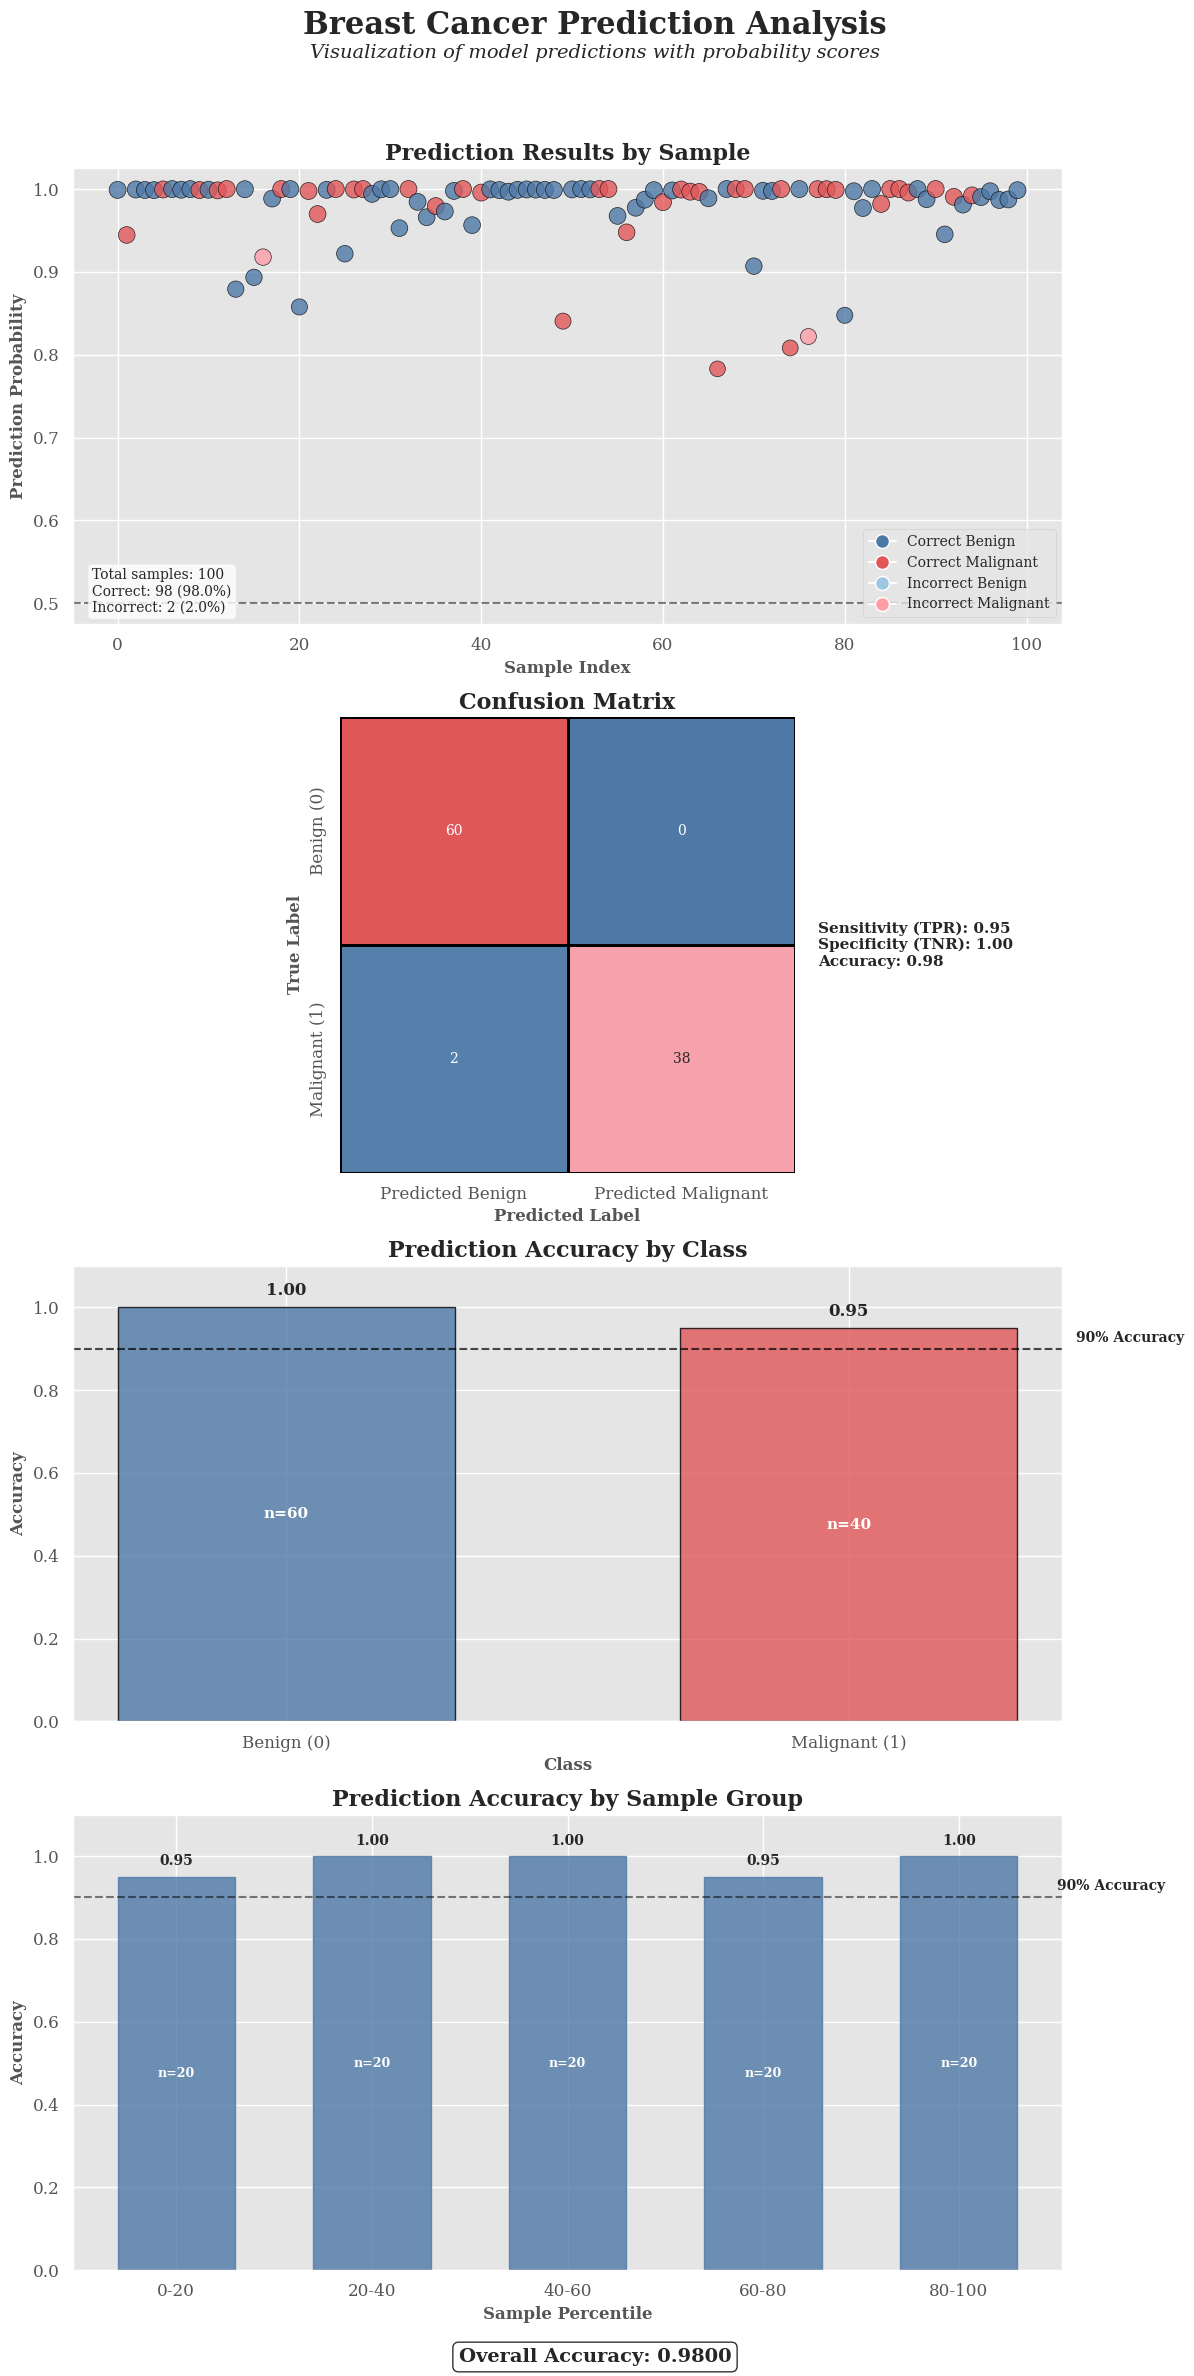

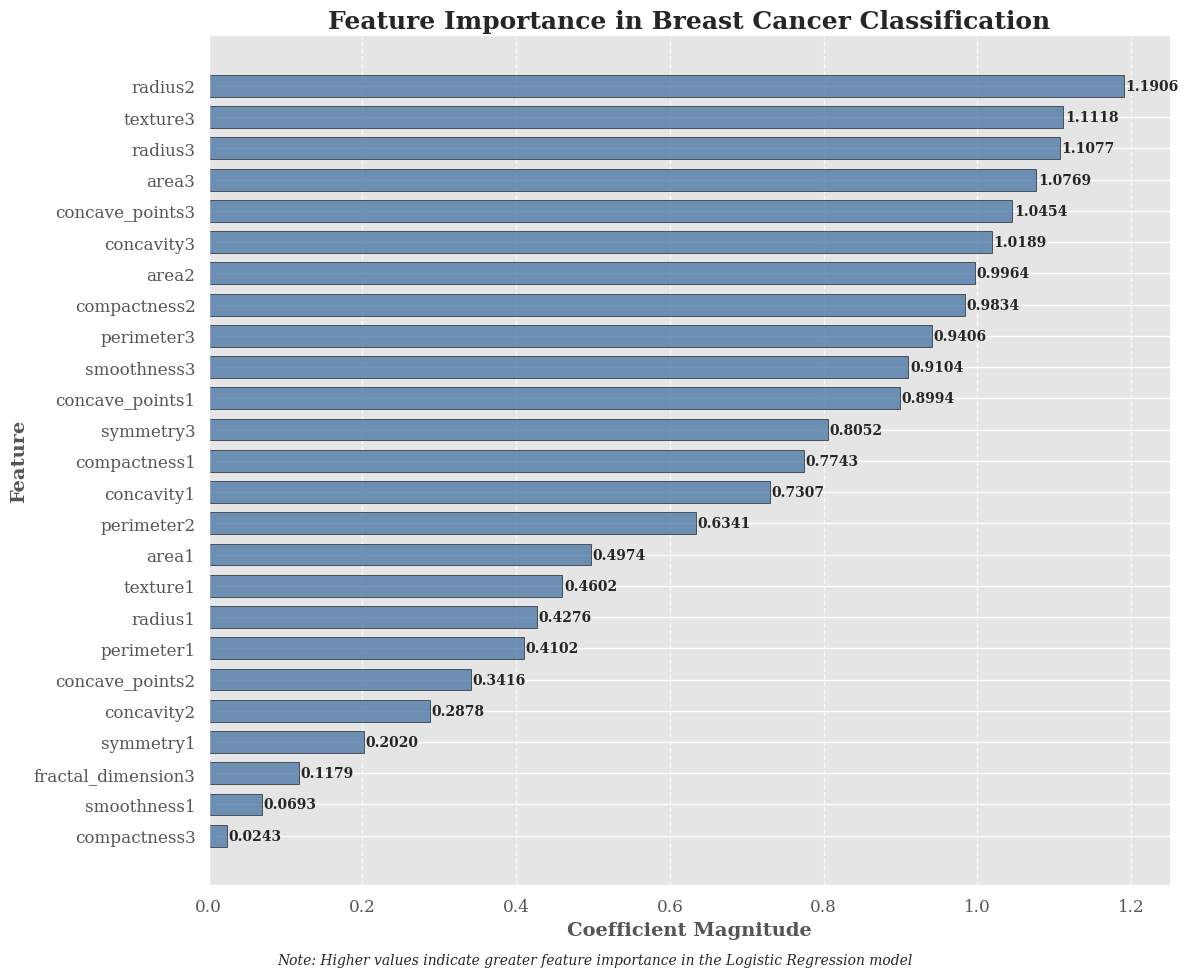

Overall accuracy: 0.9800
Benign accuracy: 1.0000
Malignant accuracy: 0.9500


In [37]:
# Visualize results of classifier
fig1, results_df = visualize_predictions(pipeline, X_test, y_test, num_samples=100)
plt.show()

# Visualize feature importance
fig2 = visualize_feature_importance(pipeline, X, significant_features)
plt.show()

print(f"Overall accuracy: {results_df['Correct'].mean():.4f}")
print(f"Benign accuracy: {results_df[results_df['True'] == 0]['Correct'].mean():.4f}")
print(f"Malignant accuracy: {results_df[results_df['True'] == 1]['Correct'].mean():.4f}")

## Healthcare System Models

There are many healthcare models designed to treat patients. Four of the most common healthcare models are

1.  **The Beveridge Model**: Tax-funded healthcare system where the government  provides and finances healthcare services through tax payments. All citizens have equal access, and the government owns most facilities and employs healthcare professionals. Example: UK's National Health Service (NHS).

2. **The Bismarck Model:** Insurance-based system jointly funded by employers and employees through payroll deductions. Insurance plans are non-profit and cover everyone, with significant government control over costs. Examples: Germany, France, Belgium, Netherlands, Japan, Switzerland.

3. **The National Health Insurance Model:** Hybrid system combining elements from Beveridge and Bismarck models. Healthcare providers are private, but the government runs the insurance program through taxation. Examples: Canada, South Korea, Taiwan.

4. **The Out-of-Pocket Model:** System where patients pay directly for medical services with minimal government involvement or insurance coverage. This creates significant healthcare disparities as only those who can afford care receive it. Common in developing nations across Africa, South America, and parts of Asia.

For cancer patients, another commonly used healthcare model is known as the
**Friedreich Ataxia healthcare model**. This model consists of the following core components

1. **Input: Clinical Data Collection**
  - Patient information and mammogram/ultrasound results form the initial dataset

2. **Processing: Information Management**
  - Machine learning algorithms classify breast tissue images as benign or malignant
  - State space model tracks disease progression and predicts outcomes

3. **Database: Medical Big Data**
  - Instead of EFACTS, the system would connect to breast cancer registries and databases

4. **Output: Personalized Care**
  - Individualized prognosis based on tumor characteristics
  - Personalized treatment plans adapted to patient-specific factors
  - Real-time monitoring of treatment response
  - Feedback loop to improve the diagnostic model

This system can be used to leverage ML classification and state space modeling to provide more accurate breast cancer diagnosis and personalized treatment recommendations based on comprehensive data analysis. A visualization of the steps in the Friedreich Ataxia healthcare model is shown below.

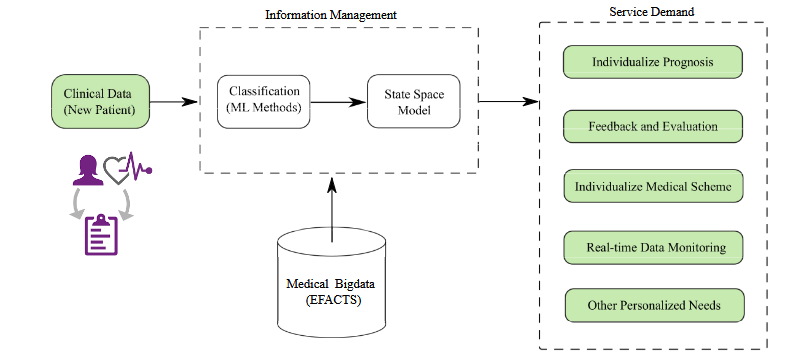

**Figure:** Flow diagram of the steps used in the Friedreich Ataxia healthcare model as described in [this paper](https://www.mdpi.com/2411-9660/2/2/13).

## Discussion and Recommendations

Conclusions from our analysis:

- In this project, we predicted whether breast masses are benign or malignant using the Wisconsin Breast Cancer Diagnostic dataset. The dataset contains features computed from digitized images of fine needle aspirates (FNA) of breast masses.
- As our target variable (diagnosis of breast cancer) is binary and we know the target and feature variables, we created a supervised classification machine learning model. We tested several algorithms including Logistic Regression, KNN, Random Forest, Support Vector Machine, and XGBoost. We found that our Logistic Regression model had the best performance metrics.
- Our original model had a baseline accuracy of 62.6\%. After performing our optimal machine learning algorithm, the accuracy increased to 98.25\%. So, our best performing model accurately predicted breast cancer on the Wisconsin dataset.

Recommendations for further research:

- The most common types of cancer in the US are breast cancer, lung cancer, colorectal cancer, prostate cancer, and skin cancer (melanoma). Breast cancer is the most common for women, while prostate cancer is the most common for men. A similar study could be be performed for a different type of cancer.
-  We could compare the Winconsin Breast Cancer dataset with other breast cancer datasets (or real-world hospital data) and see how well our ML pipeline works in the wild.

